In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Importando os dados

In [2]:
df = pd.read_csv('train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


# Normalizando os dados (media = 0 e desv_pad = 1)

In [3]:
# meanx = x_train.mean(axis = 0)
# stdx = x_train.std(axis = 0)
# x_train_norm = (x_train - meanx)/stdx
# x_val_norm = (x_val - meanx)/stdx
# x_test_norm = (x_test - meanx)/stdx
# x_train_norm=np.asarray(x_train_norm)
# x_test_norm=np.asarray(x_test_norm)
# x_val_norm=np.asarray(x_val_norm)

meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

# Metrica de avaliacao, F1 Score (basicamente traduz a matrix de confusao em uma porcentagem)

In [4]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Definindo uma classe para facilitar o trabalho com as redes

In [6]:
import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

In [8]:
class new_rna:
    def build_model(self,data_shape,units_list,activation_list):
        self.model = models.Sequential()
        my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
        for i in range(len(units_list)):
            if i == 0:
                self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i], kernel_initializer = my_init,
                                            input_shape=data_shape))
            else:
                self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i]))
        self.model.summary()
           
    def train(self,x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric):
        mom = optimizers.SGD(lr=0.0005, decay=0, momentum=0.9, nesterov=True)
        self.model.compile(loss = [loss],metrics = [metric], optimizer = mom)
        history = self.model.fit(x_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (x_val,y_val))
        self.history_dict = history.history
        self.aux_train = 1
        
    def plot(self):
        if (self.aux_train == 1):
            self.aux_plt = 1
            cost = self.history_dict['loss']
            metric = self.history_dict['f1']
            val_cost = self.history_dict['val_loss']
            val_metric = self.history_dict['val_f1']
            aux_epocas = range(1,len(cost)+1)
            plt.plot(aux_epocas,cost,'b',label = 'Custo - treinamento', color = 'red')
            plt.plot(aux_epocas,val_cost,'b',label = 'Custo - validacao', color = 'blue')
            plt.title(' Valor da Funcao Custo = Treinamento e Validacao')
            plt.xlabel('Épocas')
            plt.ylabel('Custo')
            plt.legend()
            plt.show()
            plt.plot(aux_epocas, metric,'b',label = 'metrica - treinamento',color = 'red')
            plt.plot(aux_epocas, val_metric,'b',label = 'metrica - validacao', color = 'blue')
            plt.title('Valor da métrica – treinamento e validação')
            plt.xlabel('Épocas')
            plt.ylabel('Acertividade')
            plt.legend()
            plt.show()
        else:
            print('Train before plot')

    def predict(self,x_data,y_data):
        if (self.aux_plt == 1):
            class_names = np.array([['Honest'],['Fraud']])
            subtitle = ['Test', 'Val', 'Train']
            for i in range(len(x_data)):
                y_hat = self.model.predict(x_data[i])
                yy_hat = np.round(y_hat)
                yy_hat = yy_hat.astype(int)
                yy_hat = np.ravel(yy_hat)
                f1 = f1_score(y_data[i],yy_hat)
                plot_confusion_matrix(np.int_(y_data[i]), np.int_(yy_hat), classes=class_names,
                                      title='F1_Score = {0}: {1} Data'.format(f1, subtitle[i]))
                plt.show()
            K.clear_session()
        else:
            print('Train before predict')

# Balanceado a base
### Ate o presente momento os melhores resultados obtidos se deram ao fato de termos balanceado a base, seja eliminando ou copiando os samples, o problema eh que caimos em overffiting, vamos tentar solucionar esse problema com o batch normalization

### Como primeira tentantiva iremos tentar simplesmente eliminar samples com classe tipo 0, ate o ponto que a base esteja blanciada (no maximo TRES classes 0 para cada classe 1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 30)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 30)

In [10]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X.loc[fraud_index]
honest = X.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

### Vamos avaliar o desbalanceamento atual:

In [11]:
print('O desbalanceamento eh de: {}'.format(len(honest)/len(fraud)))

O desbalanceamento eh de: 8.951238929246692


### Como a base se encontra muito desbalanceada, iremos execluir aleatoriamente alguns honestos

In [12]:
honest, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)

### Vamos reavaliar o desbalanceamento:

In [13]:
print('O desbalanceamento eh de: {}'.format(len(honest)/len(fraud)))

O desbalanceamento eh de: 2.2377848542143495


### Agora que a proporcao da base se encontra mais adequada, podemos agrupa-la e seguir para os treinamentos

In [14]:
x_train = pd.concat([honest,fraud],ignore_index = False)
y_train = pd.concat([yh,yf],ignore_index=False)

### Com o Agupamento feito, iremos realizar os treinametos e ver como as redes se ajustam

In [15]:
data_shape = (200,)

loss = 'binary_crossentropy'
metric = f1
batch_size = 29
epochs = 1000

x_data = [x_test,x_val,x_train]
y_data = [y_test,y_val,y_train]

In [16]:
n_list0 = [50,1]
activation_list0 = ['tanh','sigmoid']

In [18]:
rna0 = new_rna()
rna0.build_model(data_shape,n_list0,activation_list0)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.5217 - f1: 0.4169 - val_loss: 0.3464 - val_f1: 0.3677
Epoch 2/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.4835 - f1: 0.5455 - val_loss: 0.3681 - val_f1: 0.3976
Epoch 3/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.4768 - f1: 0.5581 - val_loss: 0.2870 - val_f1: 0.3284
Epoch 4/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4724 - f1: 0.5633 - val_loss: 0.4188 - val_f1: 0.3817
Epoch 5/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.4698 - f1: 0.5656 - val_loss: 0.2938 - val_f1: 0.3430
Epoch 6/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4681 - f1: 0.5702 - val_loss: 0.3249 - val_f1: 0.4133
Epoch 7/1000
65073/65073 [==============================] - 3s 40us/step - loss:

65073/65073 [==============================] - 2s 31us/step - loss: 0.4399 - f1: 0.6153 - val_loss: 0.3609 - val_f1: 0.4214
Epoch 59/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4408 - f1: 0.6155 - val_loss: 0.3491 - val_f1: 0.4242
Epoch 60/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4394 - f1: 0.6151 - val_loss: 0.3370 - val_f1: 0.4262
Epoch 61/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4378 - f1: 0.6120 - val_loss: 0.3035 - val_f1: 0.4235
Epoch 62/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4395 - f1: 0.6108 - val_loss: 0.3154 - val_f1: 0.4175
Epoch 63/1000
65073/65073 [==============================] - 2s 30us/step - loss: 0.4389 - f1: 0.6106 - val_loss: 0.3049 - val_f1: 0.4309
Epoch 64/1000
65073/65073 [==============================] - 2s 30us/step - loss: 0.4382 - f1: 0.6126 - val_loss: 0.3228 - val_f1: 0.4289
Epoch 65/1000
65073/65073 [=====================

65073/65073 [==============================] - 2s 31us/step - loss: 0.4288 - f1: 0.6288 - val_loss: 0.2898 - val_f1: 0.4352
Epoch 118/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4294 - f1: 0.6241 - val_loss: 0.3842 - val_f1: 0.3953
Epoch 119/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4303 - f1: 0.6239 - val_loss: 0.3483 - val_f1: 0.4217
Epoch 120/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4298 - f1: 0.6304 - val_loss: 0.3227 - val_f1: 0.4292
Epoch 121/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4301 - f1: 0.6283 - val_loss: 0.3024 - val_f1: 0.4379
Epoch 122/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.4297 - f1: 0.6332 - val_loss: 0.3458 - val_f1: 0.4246
Epoch 123/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4274 - f1: 0.6290 - val_loss: 0.3280 - val_f1: 0.4361
Epoch 124/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 35us/step - loss: 0.4166 - f1: 0.6419 - val_loss: 0.3380 - val_f1: 0.4363
Epoch 177/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4164 - f1: 0.6413 - val_loss: 0.3379 - val_f1: 0.4459
Epoch 178/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4153 - f1: 0.6380 - val_loss: 0.3419 - val_f1: 0.4473
Epoch 179/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4163 - f1: 0.6410 - val_loss: 0.3263 - val_f1: 0.4327
Epoch 180/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4156 - f1: 0.6380 - val_loss: 0.2764 - val_f1: 0.4402
Epoch 181/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4146 - f1: 0.6391 - val_loss: 0.3177 - val_f1: 0.4456
Epoch 182/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.4144 - f1: 0.6433 - val_loss: 0.3244 - val_f1: 0.4430
Epoch 183/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.4003 - f1: 0.6577 - val_loss: 0.3520 - val_f1: 0.4411
Epoch 236/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3991 - f1: 0.6600 - val_loss: 0.3658 - val_f1: 0.4344
Epoch 237/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3988 - f1: 0.6634 - val_loss: 0.3050 - val_f1: 0.4479
Epoch 238/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3992 - f1: 0.6612 - val_loss: 0.3235 - val_f1: 0.4546
Epoch 239/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3994 - f1: 0.6591 - val_loss: 0.3320 - val_f1: 0.4572
Epoch 240/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3992 - f1: 0.6616 - val_loss: 0.3281 - val_f1: 0.4546
Epoch 241/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3986 - f1: 0.6589 - val_loss: 0.3394 - val_f1: 0.4518
Epoch 242/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3929 - f1: 0.6672 - val_loss: 0.3358 - val_f1: 0.4483
Epoch 295/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3902 - f1: 0.6688 - val_loss: 0.3087 - val_f1: 0.4519
Epoch 296/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3891 - f1: 0.6746 - val_loss: 0.3431 - val_f1: 0.4564
Epoch 297/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3900 - f1: 0.6733 - val_loss: 0.3228 - val_f1: 0.4548
Epoch 298/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3902 - f1: 0.6714 - val_loss: 0.3273 - val_f1: 0.4539
Epoch 299/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3887 - f1: 0.6740 - val_loss: 0.3156 - val_f1: 0.4573
Epoch 300/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3889 - f1: 0.6715 - val_loss: 0.3120 - val_f1: 0.4537
Epoch 301/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3814 - f1: 0.6812 - val_loss: 0.3164 - val_f1: 0.4593
Epoch 354/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3799 - f1: 0.6857 - val_loss: 0.3462 - val_f1: 0.4483
Epoch 355/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3821 - f1: 0.6800 - val_loss: 0.3421 - val_f1: 0.4583
Epoch 356/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3791 - f1: 0.6799 - val_loss: 0.3270 - val_f1: 0.4526
Epoch 357/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3791 - f1: 0.6807 - val_loss: 0.3102 - val_f1: 0.4616
Epoch 358/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3801 - f1: 0.6767 - val_loss: 0.3334 - val_f1: 0.4542
Epoch 359/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3800 - f1: 0.6801 - val_loss: 0.3088 - val_f1: 0.4610
Epoch 360/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3724 - f1: 0.6871 - val_loss: 0.3094 - val_f1: 0.4686
Epoch 413/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3719 - f1: 0.6927 - val_loss: 0.3523 - val_f1: 0.4544
Epoch 414/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3732 - f1: 0.6898 - val_loss: 0.3187 - val_f1: 0.4629
Epoch 415/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3714 - f1: 0.6946 - val_loss: 0.3018 - val_f1: 0.4598
Epoch 416/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3707 - f1: 0.6908 - val_loss: 0.2997 - val_f1: 0.4503
Epoch 417/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3736 - f1: 0.6881 - val_loss: 0.3197 - val_f1: 0.4706
Epoch 418/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3715 - f1: 0.6878 - val_loss: 0.3899 - val_f1: 0.4249
Epoch 419/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 35us/step - loss: 0.3654 - f1: 0.6932 - val_loss: 0.3008 - val_f1: 0.4667
Epoch 472/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3657 - f1: 0.6929 - val_loss: 0.3157 - val_f1: 0.4684
Epoch 473/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3640 - f1: 0.6970 - val_loss: 0.3061 - val_f1: 0.4709
Epoch 474/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3643 - f1: 0.6966 - val_loss: 0.3305 - val_f1: 0.4597
Epoch 475/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3645 - f1: 0.6964 - val_loss: 0.2952 - val_f1: 0.4686
Epoch 476/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3633 - f1: 0.6989 - val_loss: 0.3393 - val_f1: 0.4584
Epoch 477/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3646 - f1: 0.6949 - val_loss: 0.3331 - val_f1: 0.4506
Epoch 478/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3588 - f1: 0.7065 - val_loss: 0.3008 - val_f1: 0.4621
Epoch 531/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3592 - f1: 0.7069 - val_loss: 0.3035 - val_f1: 0.4680
Epoch 532/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3598 - f1: 0.7022 - val_loss: 0.3366 - val_f1: 0.4663
Epoch 533/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3601 - f1: 0.7043 - val_loss: 0.3065 - val_f1: 0.4749
Epoch 534/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3586 - f1: 0.7046 - val_loss: 0.3353 - val_f1: 0.4665
Epoch 535/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3593 - f1: 0.7006 - val_loss: 0.3325 - val_f1: 0.4520
Epoch 536/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3589 - f1: 0.7067 - val_loss: 0.3444 - val_f1: 0.4679
Epoch 537/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3530 - f1: 0.7091 - val_loss: 0.3136 - val_f1: 0.4783
Epoch 590/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3551 - f1: 0.7099 - val_loss: 0.3353 - val_f1: 0.4753
Epoch 591/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3561 - f1: 0.7080 - val_loss: 0.2962 - val_f1: 0.4719
Epoch 592/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3538 - f1: 0.7086 - val_loss: 0.3449 - val_f1: 0.4551
Epoch 593/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3535 - f1: 0.7096 - val_loss: 0.3161 - val_f1: 0.4714
Epoch 594/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3549 - f1: 0.7058 - val_loss: 0.3449 - val_f1: 0.4613
Epoch 595/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3538 - f1: 0.7110 - val_loss: 0.3362 - val_f1: 0.4597
Epoch 596/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3495 - f1: 0.7111 - val_loss: 0.3508 - val_f1: 0.4669
Epoch 649/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3509 - f1: 0.7127 - val_loss: 0.3432 - val_f1: 0.4638
Epoch 650/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3537 - f1: 0.7060 - val_loss: 0.3701 - val_f1: 0.4629
Epoch 651/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3505 - f1: 0.7137 - val_loss: 0.3092 - val_f1: 0.4856
Epoch 652/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3512 - f1: 0.7132 - val_loss: 0.3546 - val_f1: 0.4689
Epoch 653/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3490 - f1: 0.7154 - val_loss: 0.3504 - val_f1: 0.4686
Epoch 654/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3484 - f1: 0.7163 - val_loss: 0.3323 - val_f1: 0.4729
Epoch 655/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3504 - f1: 0.7152 - val_loss: 0.3436 - val_f1: 0.4620
Epoch 708/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3514 - f1: 0.7143 - val_loss: 0.3200 - val_f1: 0.4687
Epoch 709/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3475 - f1: 0.7206 - val_loss: 0.3558 - val_f1: 0.4561
Epoch 710/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3548 - f1: 0.7097 - val_loss: 0.3212 - val_f1: 0.4641
Epoch 711/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3517 - f1: 0.7160 - val_loss: 0.3086 - val_f1: 0.4695
Epoch 712/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3513 - f1: 0.7139 - val_loss: 0.3340 - val_f1: 0.4684
Epoch 713/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3529 - f1: 0.7138 - val_loss: 0.3280 - val_f1: 0.4770
Epoch 714/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 35us/step - loss: 0.3475 - f1: 0.7154 - val_loss: 0.3307 - val_f1: 0.4738
Epoch 767/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3475 - f1: 0.7123 - val_loss: 0.3730 - val_f1: 0.4551
Epoch 768/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3465 - f1: 0.7168 - val_loss: 0.3544 - val_f1: 0.4560
Epoch 769/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3467 - f1: 0.7168 - val_loss: 0.3297 - val_f1: 0.4617
Epoch 770/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3449 - f1: 0.7192 - val_loss: 0.3224 - val_f1: 0.4697
Epoch 771/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3447 - f1: 0.7194 - val_loss: 0.3926 - val_f1: 0.4525
Epoch 772/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3457 - f1: 0.7199 - val_loss: 0.3032 - val_f1: 0.4675
Epoch 773/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 32us/step - loss: 0.3415 - f1: 0.7205 - val_loss: 0.3554 - val_f1: 0.4605
Epoch 826/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3433 - f1: 0.7217 - val_loss: 0.3115 - val_f1: 0.4785
Epoch 827/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3421 - f1: 0.7183 - val_loss: 0.3602 - val_f1: 0.4692
Epoch 828/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3417 - f1: 0.7200 - val_loss: 0.3142 - val_f1: 0.4690
Epoch 829/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3392 - f1: 0.7262 - val_loss: 0.3387 - val_f1: 0.4726
Epoch 830/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3395 - f1: 0.7240 - val_loss: 0.3556 - val_f1: 0.4681
Epoch 831/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3401 - f1: 0.7233 - val_loss: 0.3478 - val_f1: 0.4627
Epoch 832/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 32us/step - loss: 0.3407 - f1: 0.7217 - val_loss: 0.3388 - val_f1: 0.4752
Epoch 885/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3427 - f1: 0.7269 - val_loss: 0.3328 - val_f1: 0.4710
Epoch 886/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3420 - f1: 0.7190 - val_loss: 0.3100 - val_f1: 0.4735
Epoch 887/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3403 - f1: 0.7226 - val_loss: 0.3599 - val_f1: 0.4804
Epoch 888/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3411 - f1: 0.7224 - val_loss: 0.3164 - val_f1: 0.4833
Epoch 889/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3399 - f1: 0.7227 - val_loss: 0.3649 - val_f1: 0.4741
Epoch 890/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3403 - f1: 0.7248 - val_loss: 0.3602 - val_f1: 0.4630
Epoch 891/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3367 - f1: 0.7263 - val_loss: 0.3307 - val_f1: 0.4779
Epoch 944/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.3371 - f1: 0.7274 - val_loss: 0.3445 - val_f1: 0.4716
Epoch 945/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3400 - f1: 0.7237 - val_loss: 0.3648 - val_f1: 0.4713
Epoch 946/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3403 - f1: 0.7227 - val_loss: 0.3352 - val_f1: 0.4744
Epoch 947/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3368 - f1: 0.7283 - val_loss: 0.3382 - val_f1: 0.4824
Epoch 948/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3379 - f1: 0.7277 - val_loss: 0.3366 - val_f1: 0.4723
Epoch 949/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3382 - f1: 0.7192 - val_loss: 0.3768 - val_f1: 0.4595
Epoch 950/1000
65073/65073 [==============

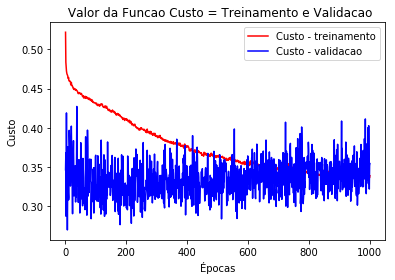

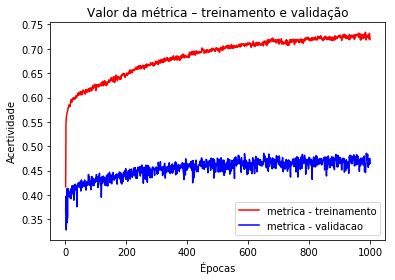

In [19]:
rna0.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna0.plot()

Confusion matrix, without normalization
[[15848  2089]
 [  698  1365]]


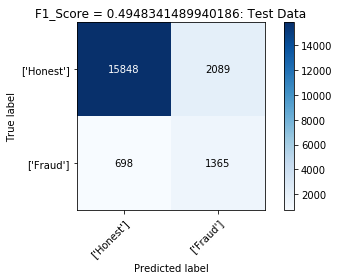

Confusion matrix, without normalization
[[15954  2028]
 [  630  1388]]


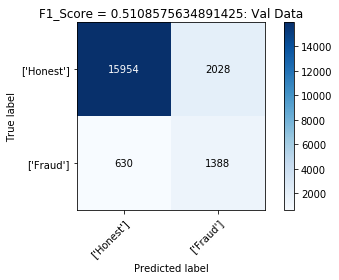

Confusion matrix, without normalization
[[41917  3058]
 [ 6634 13464]]


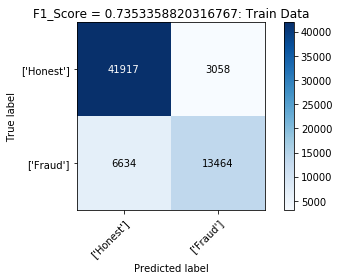

In [20]:
rna0.predict(x_data,y_data)

In [21]:
n_list1 = [100,1]
activation_list1 = ['tanh','sigmoid']

In [22]:
rna1 = new_rna()
rna1.build_model(data_shape,n_list1,activation_list1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.5207 - f1: 0.4246 - val_loss: 0.3708 - val_f1: 0.3705
Epoch 2/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4827 - f1: 0.5371 - val_loss: 0.3552 - val_f1: 0.3956
Epoch 3/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4730 - f1: 0.5581 - val_loss: 0.3498 - val_f1: 0.3999
Epoch 4/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4728 - f1: 0.5578 - val_loss: 0.4039 - val_f1: 0.4063
Epoch 5/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4676 - f1: 0.5682 - val_loss: 0.3795 - val_f1: 0.4015
Epoch 6/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4653 - f1: 0.5713 - val_loss: 0.4970 - val_f1: 0.3581
Epoch 7/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4645 - f1: 0.5781 - val_loss: 0.3140 - val_f1

65073/65073 [==============================] - 2s 33us/step - loss: 0.4364 - f1: 0.6184 - val_loss: 0.3706 - val_f1: 0.4119
Epoch 61/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4355 - f1: 0.6190 - val_loss: 0.3426 - val_f1: 0.4252
Epoch 62/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4390 - f1: 0.6161 - val_loss: 0.3382 - val_f1: 0.4267
Epoch 63/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.4367 - f1: 0.6175 - val_loss: 0.3122 - val_f1: 0.4330
Epoch 64/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4351 - f1: 0.6185 - val_loss: 0.3726 - val_f1: 0.4215
Epoch 65/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4357 - f1: 0.6184 - val_loss: 0.3407 - val_f1: 0.4310
Epoch 66/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4349 - f1: 0.6192 - val_loss: 0.3147 - val_f1: 0.4349
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 2s 34us/step - loss: 0.4137 - f1: 0.6490 - val_loss: 0.3390 - val_f1: 0.4383
Epoch 120/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4158 - f1: 0.6465 - val_loss: 0.3535 - val_f1: 0.4267
Epoch 121/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4132 - f1: 0.6440 - val_loss: 0.3268 - val_f1: 0.4445
Epoch 122/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4133 - f1: 0.6485 - val_loss: 0.2896 - val_f1: 0.4202
Epoch 123/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4135 - f1: 0.6479 - val_loss: 0.3768 - val_f1: 0.4195
Epoch 124/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4124 - f1: 0.6487 - val_loss: 0.3416 - val_f1: 0.4348
Epoch 125/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4101 - f1: 0.6481 - val_loss: 0.3319 - val_f1: 0.4378
Epoch 126/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3791 - f1: 0.6877 - val_loss: 0.2960 - val_f1: 0.4643
Epoch 179/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3810 - f1: 0.6844 - val_loss: 0.2872 - val_f1: 0.4658
Epoch 180/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3802 - f1: 0.6845 - val_loss: 0.3145 - val_f1: 0.4658
Epoch 181/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3774 - f1: 0.6888 - val_loss: 0.3515 - val_f1: 0.4515
Epoch 182/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3784 - f1: 0.6870 - val_loss: 0.2999 - val_f1: 0.4626
Epoch 183/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3771 - f1: 0.6888 - val_loss: 0.3423 - val_f1: 0.4600
Epoch 184/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3743 - f1: 0.6927 - val_loss: 0.3348 - val_f1: 0.4675
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 33us/step - loss: 0.3488 - f1: 0.7171 - val_loss: 0.2995 - val_f1: 0.4746
Epoch 238/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3503 - f1: 0.7185 - val_loss: 0.3260 - val_f1: 0.4672
Epoch 239/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3470 - f1: 0.7216 - val_loss: 0.3414 - val_f1: 0.4569
Epoch 240/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3466 - f1: 0.7216 - val_loss: 0.3432 - val_f1: 0.4583
Epoch 241/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3463 - f1: 0.7180 - val_loss: 0.3279 - val_f1: 0.4630
Epoch 242/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3466 - f1: 0.7221 - val_loss: 0.3299 - val_f1: 0.4713
Epoch 243/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3474 - f1: 0.7206 - val_loss: 0.3230 - val_f1: 0.4774
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3311 - f1: 0.7382 - val_loss: 0.3243 - val_f1: 0.4793
Epoch 297/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3312 - f1: 0.7373 - val_loss: 0.3869 - val_f1: 0.4573
Epoch 298/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3291 - f1: 0.7410 - val_loss: 0.3451 - val_f1: 0.4515
Epoch 299/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3274 - f1: 0.7403 - val_loss: 0.3015 - val_f1: 0.4726
Epoch 300/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3291 - f1: 0.7419 - val_loss: 0.3255 - val_f1: 0.4672
Epoch 301/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3301 - f1: 0.7379 - val_loss: 0.3424 - val_f1: 0.4607
Epoch 302/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3283 - f1: 0.7390 - val_loss: 0.3544 - val_f1: 0.4605
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3080 - f1: 0.7602 - val_loss: 0.3702 - val_f1: 0.4694
Epoch 356/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3075 - f1: 0.7641 - val_loss: 0.3614 - val_f1: 0.4608
Epoch 357/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3105 - f1: 0.7553 - val_loss: 0.3518 - val_f1: 0.4614
Epoch 358/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.3093 - f1: 0.7584 - val_loss: 0.3531 - val_f1: 0.4731
Epoch 359/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3088 - f1: 0.7611 - val_loss: 0.3625 - val_f1: 0.4667
Epoch 360/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3080 - f1: 0.7613 - val_loss: 0.3757 - val_f1: 0.4717
Epoch 361/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3082 - f1: 0.7638 - val_loss: 0.3636 - val_f1: 0.4596
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.2932 - f1: 0.7763 - val_loss: 0.3675 - val_f1: 0.4730
Epoch 415/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2948 - f1: 0.7711 - val_loss: 0.3531 - val_f1: 0.4792
Epoch 416/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2947 - f1: 0.7729 - val_loss: 0.3988 - val_f1: 0.4627
Epoch 417/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2967 - f1: 0.7717 - val_loss: 0.3106 - val_f1: 0.4901
Epoch 418/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2964 - f1: 0.7707 - val_loss: 0.3457 - val_f1: 0.4808
Epoch 419/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2913 - f1: 0.7767 - val_loss: 0.3715 - val_f1: 0.4700
Epoch 420/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2931 - f1: 0.7731 - val_loss: 0.3245 - val_f1: 0.4910
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 33us/step - loss: 0.2851 - f1: 0.7818 - val_loss: 0.3768 - val_f1: 0.4813
Epoch 474/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2843 - f1: 0.7848 - val_loss: 0.3562 - val_f1: 0.4851
Epoch 475/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2823 - f1: 0.7854 - val_loss: 0.3571 - val_f1: 0.4879
Epoch 476/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2829 - f1: 0.7856 - val_loss: 0.3438 - val_f1: 0.4918
Epoch 477/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2823 - f1: 0.7849 - val_loss: 0.3831 - val_f1: 0.4795
Epoch 478/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2846 - f1: 0.7816 - val_loss: 0.3477 - val_f1: 0.4791
Epoch 479/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2819 - f1: 0.7852 - val_loss: 0.3655 - val_f1: 0.4846
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.2742 - f1: 0.7919 - val_loss: 0.3477 - val_f1: 0.4942
Epoch 533/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2688 - f1: 0.8018 - val_loss: 0.3699 - val_f1: 0.4838
Epoch 534/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2714 - f1: 0.7982 - val_loss: 0.3712 - val_f1: 0.4856
Epoch 535/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2683 - f1: 0.8001 - val_loss: 0.3397 - val_f1: 0.4923
Epoch 536/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2733 - f1: 0.7934 - val_loss: 0.3769 - val_f1: 0.4857
Epoch 537/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2697 - f1: 0.7999 - val_loss: 0.3398 - val_f1: 0.4976
Epoch 538/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2715 - f1: 0.7955 - val_loss: 0.3564 - val_f1: 0.5015
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.2609 - f1: 0.8071 - val_loss: 0.3491 - val_f1: 0.5007
Epoch 592/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2595 - f1: 0.8086 - val_loss: 0.3916 - val_f1: 0.4911
Epoch 593/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2593 - f1: 0.8064 - val_loss: 0.3428 - val_f1: 0.4975
Epoch 594/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2576 - f1: 0.8101 - val_loss: 0.3901 - val_f1: 0.4780
Epoch 595/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2568 - f1: 0.8120 - val_loss: 0.3725 - val_f1: 0.4946
Epoch 596/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2597 - f1: 0.8063 - val_loss: 0.4125 - val_f1: 0.4784
Epoch 597/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2600 - f1: 0.8067 - val_loss: 0.3629 - val_f1: 0.4943
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.2551 - f1: 0.8117 - val_loss: 0.4379 - val_f1: 0.4631
Epoch 651/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2567 - f1: 0.8118 - val_loss: 0.4026 - val_f1: 0.4805
Epoch 652/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2587 - f1: 0.8105 - val_loss: 0.4455 - val_f1: 0.4689
Epoch 653/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2578 - f1: 0.8073 - val_loss: 0.3974 - val_f1: 0.4873
Epoch 654/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2559 - f1: 0.8105 - val_loss: 0.3871 - val_f1: 0.4923
Epoch 655/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2563 - f1: 0.8114 - val_loss: 0.3862 - val_f1: 0.4835
Epoch 656/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2578 - f1: 0.8083 - val_loss: 0.4189 - val_f1: 0.4597
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.2448 - f1: 0.8185 - val_loss: 0.4292 - val_f1: 0.4721
Epoch 710/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2442 - f1: 0.8226 - val_loss: 0.4290 - val_f1: 0.4691
Epoch 711/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2444 - f1: 0.8227 - val_loss: 0.4528 - val_f1: 0.4705
Epoch 712/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2449 - f1: 0.8205 - val_loss: 0.3590 - val_f1: 0.4973
Epoch 713/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2446 - f1: 0.8221 - val_loss: 0.4346 - val_f1: 0.4866
Epoch 714/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2467 - f1: 0.8183 - val_loss: 0.4007 - val_f1: 0.4894
Epoch 715/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2475 - f1: 0.8162 - val_loss: 0.3820 - val_f1: 0.4886
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.2441 - f1: 0.8231 - val_loss: 0.3993 - val_f1: 0.4846
Epoch 769/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2445 - f1: 0.8187 - val_loss: 0.4213 - val_f1: 0.4844
Epoch 770/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2469 - f1: 0.8195 - val_loss: 0.4388 - val_f1: 0.4729
Epoch 771/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2432 - f1: 0.8219 - val_loss: 0.3535 - val_f1: 0.5061
Epoch 772/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2445 - f1: 0.8216 - val_loss: 0.3685 - val_f1: 0.4958
Epoch 773/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2443 - f1: 0.8223 - val_loss: 0.4580 - val_f1: 0.4625
Epoch 774/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2412 - f1: 0.8231 - val_loss: 0.3719 - val_f1: 0.5058
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.2332 - f1: 0.8296 - val_loss: 0.3846 - val_f1: 0.5057
Epoch 828/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2306 - f1: 0.8356 - val_loss: 0.3855 - val_f1: 0.5046
Epoch 829/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2296 - f1: 0.8370 - val_loss: 0.3917 - val_f1: 0.4945
Epoch 830/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2308 - f1: 0.8318 - val_loss: 0.3687 - val_f1: 0.5109
Epoch 831/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2349 - f1: 0.8299 - val_loss: 0.3813 - val_f1: 0.5021
Epoch 832/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2311 - f1: 0.8357 - val_loss: 0.3809 - val_f1: 0.5057
Epoch 833/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2293 - f1: 0.8342 - val_loss: 0.4382 - val_f1: 0.4802
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.2237 - f1: 0.8380 - val_loss: 0.4283 - val_f1: 0.4857
Epoch 887/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.2245 - f1: 0.8414 - val_loss: 0.4380 - val_f1: 0.4862
Epoch 888/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2284 - f1: 0.8337 - val_loss: 0.4156 - val_f1: 0.4993
Epoch 889/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2249 - f1: 0.8376 - val_loss: 0.3761 - val_f1: 0.5131
Epoch 890/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2253 - f1: 0.8379 - val_loss: 0.3936 - val_f1: 0.4998
Epoch 891/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2275 - f1: 0.8351 - val_loss: 0.3412 - val_f1: 0.5137
Epoch 892/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2227 - f1: 0.8407 - val_loss: 0.3867 - val_f1: 0.5055
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.2182 - f1: 0.8448 - val_loss: 0.4468 - val_f1: 0.4854
Epoch 946/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2181 - f1: 0.8435 - val_loss: 0.4090 - val_f1: 0.4906
Epoch 947/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2191 - f1: 0.8424 - val_loss: 0.3703 - val_f1: 0.5180
Epoch 948/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2149 - f1: 0.8454 - val_loss: 0.4135 - val_f1: 0.5029
Epoch 949/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2142 - f1: 0.8482 - val_loss: 0.4078 - val_f1: 0.5019
Epoch 950/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2169 - f1: 0.8448 - val_loss: 0.4162 - val_f1: 0.4969
Epoch 951/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2144 - f1: 0.8464 - val_loss: 0.4057 - val_f1: 0.5033
Epoch 952/1000
65073/65073 [==============

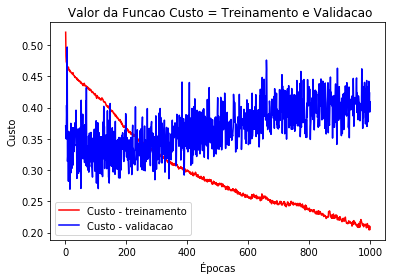

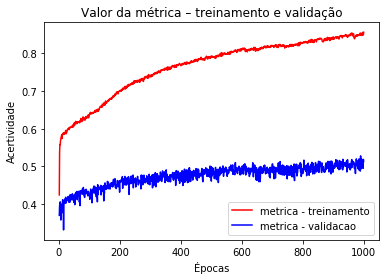

In [23]:
rna1.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna1.plot()

Confusion matrix, without normalization
[[15475  2462]
 [  314  1749]]


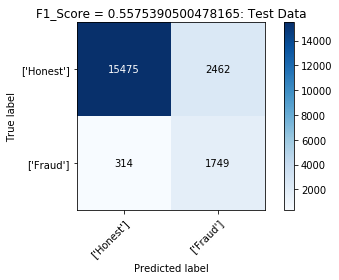

Confusion matrix, without normalization
[[15429  2553]
 [  294  1724]]


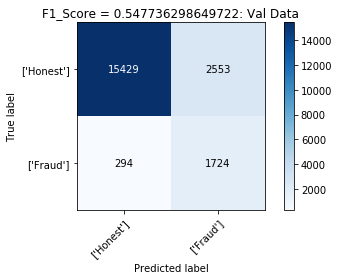

Confusion matrix, without normalization
[[42893  2082]
 [ 3024 17074]]


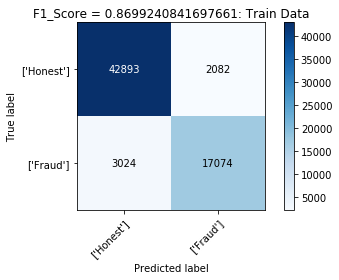

In [24]:
rna1.predict(x_data,y_data)

In [25]:
n_list2 = [50,50,1]
activation_list2 = ['tanh','tanh','sigmoid']

In [26]:
rna2 = new_rna()
rna2.build_model(data_shape,n_list2,activation_list2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.5329 - f1: 0.3536 - val_loss: 0.3270 - val_f1: 0.3376
Epoch 2/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4925 - f1: 0.5275 - val_loss: 0.3452 - val_f1: 0.3850
Epoch 3/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.4866 - f1: 0.5392 - val_loss: 0.4319 - val_f1: 0.3755
Epoch 4/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4811 - f1: 0.5544 - val_loss: 0.3156 - val_f1: 0.3865
Epoch 5/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4747 - f1: 0.5631 - val_loss: 0.3500 - val_f1: 0.3857
Epoch 6/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4707 - f1: 0.5669 - val_loss: 0.3922 - val_f1: 0.3896
Epoch 7/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4687 - f1: 0.5660 - val_loss: 0.3822 - val_f1

65073/65073 [==============================] - 2s 36us/step - loss: 0.4463 - f1: 0.6070 - val_loss: 0.3746 - val_f1: 0.4235
Epoch 61/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4458 - f1: 0.6045 - val_loss: 0.3347 - val_f1: 0.4018
Epoch 62/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4449 - f1: 0.6078 - val_loss: 0.3613 - val_f1: 0.4179
Epoch 63/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4448 - f1: 0.6074 - val_loss: 0.3172 - val_f1: 0.3885
Epoch 64/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4445 - f1: 0.6090 - val_loss: 0.3181 - val_f1: 0.4369
Epoch 65/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4441 - f1: 0.6101 - val_loss: 0.3206 - val_f1: 0.4249
Epoch 66/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4449 - f1: 0.6051 - val_loss: 0.2884 - val_f1: 0.4001
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 2s 37us/step - loss: 0.4307 - f1: 0.6220 - val_loss: 0.3818 - val_f1: 0.4237
Epoch 120/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4317 - f1: 0.6246 - val_loss: 0.3538 - val_f1: 0.4338
Epoch 121/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4313 - f1: 0.6245 - val_loss: 0.3077 - val_f1: 0.4195
Epoch 122/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4292 - f1: 0.6232 - val_loss: 0.3709 - val_f1: 0.4212
Epoch 123/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4296 - f1: 0.6250 - val_loss: 0.3631 - val_f1: 0.4157
Epoch 124/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4281 - f1: 0.6306 - val_loss: 0.2885 - val_f1: 0.4133
Epoch 125/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4268 - f1: 0.6271 - val_loss: 0.2988 - val_f1: 0.4387
Epoch 126/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.4063 - f1: 0.6538 - val_loss: 0.3001 - val_f1: 0.4390
Epoch 179/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4064 - f1: 0.6537 - val_loss: 0.3100 - val_f1: 0.4429
Epoch 180/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4069 - f1: 0.6496 - val_loss: 0.3658 - val_f1: 0.4378
Epoch 181/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4063 - f1: 0.6555 - val_loss: 0.3180 - val_f1: 0.4401
Epoch 182/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4069 - f1: 0.6533 - val_loss: 0.2905 - val_f1: 0.4436
Epoch 183/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.4045 - f1: 0.6555 - val_loss: 0.3037 - val_f1: 0.4368
Epoch 184/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4048 - f1: 0.6552 - val_loss: 0.3112 - val_f1: 0.4434
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3855 - f1: 0.6770 - val_loss: 0.3204 - val_f1: 0.4424
Epoch 238/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3828 - f1: 0.6802 - val_loss: 0.3838 - val_f1: 0.4307
Epoch 239/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3814 - f1: 0.6820 - val_loss: 0.3476 - val_f1: 0.4328
Epoch 240/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3843 - f1: 0.6788 - val_loss: 0.3302 - val_f1: 0.4430
Epoch 241/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3846 - f1: 0.6797 - val_loss: 0.3360 - val_f1: 0.4262
Epoch 242/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3837 - f1: 0.6798 - val_loss: 0.3111 - val_f1: 0.4388
Epoch 243/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3838 - f1: 0.6807 - val_loss: 0.3192 - val_f1: 0.4466
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3687 - f1: 0.6977 - val_loss: 0.3839 - val_f1: 0.4361
Epoch 297/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3694 - f1: 0.6965 - val_loss: 0.2846 - val_f1: 0.4560
Epoch 298/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3685 - f1: 0.6975 - val_loss: 0.3098 - val_f1: 0.4559
Epoch 299/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3688 - f1: 0.6991 - val_loss: 0.3449 - val_f1: 0.4405
Epoch 300/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3690 - f1: 0.6957 - val_loss: 0.3078 - val_f1: 0.4553
Epoch 301/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3690 - f1: 0.6967 - val_loss: 0.3315 - val_f1: 0.4462
Epoch 302/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3670 - f1: 0.6964 - val_loss: 0.3239 - val_f1: 0.4379
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 35us/step - loss: 0.3540 - f1: 0.7098 - val_loss: 0.3449 - val_f1: 0.4410
Epoch 356/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3538 - f1: 0.7130 - val_loss: 0.3221 - val_f1: 0.4607
Epoch 357/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3540 - f1: 0.7115 - val_loss: 0.3367 - val_f1: 0.4500
Epoch 358/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3545 - f1: 0.7108 - val_loss: 0.3666 - val_f1: 0.4449
Epoch 359/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3541 - f1: 0.7128 - val_loss: 0.3273 - val_f1: 0.4585
Epoch 360/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3556 - f1: 0.7102 - val_loss: 0.3551 - val_f1: 0.4480
Epoch 361/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3518 - f1: 0.7106 - val_loss: 0.3159 - val_f1: 0.4575
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3459 - f1: 0.7217 - val_loss: 0.3465 - val_f1: 0.4497
Epoch 415/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3472 - f1: 0.7177 - val_loss: 0.3469 - val_f1: 0.4522
Epoch 416/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3490 - f1: 0.7174 - val_loss: 0.3554 - val_f1: 0.4522
Epoch 417/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3470 - f1: 0.7177 - val_loss: 0.3424 - val_f1: 0.4566
Epoch 418/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3458 - f1: 0.7210 - val_loss: 0.2758 - val_f1: 0.4616
Epoch 419/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3458 - f1: 0.7188 - val_loss: 0.3265 - val_f1: 0.4650
Epoch 420/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3462 - f1: 0.7190 - val_loss: 0.3442 - val_f1: 0.4411
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3420 - f1: 0.7233 - val_loss: 0.3863 - val_f1: 0.4352
Epoch 474/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3396 - f1: 0.7257 - val_loss: 0.3436 - val_f1: 0.4487
Epoch 475/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3403 - f1: 0.7275 - val_loss: 0.3532 - val_f1: 0.4519
Epoch 476/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3441 - f1: 0.7202 - val_loss: 0.3760 - val_f1: 0.4409
Epoch 477/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3409 - f1: 0.7225 - val_loss: 0.3570 - val_f1: 0.4506
Epoch 478/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3395 - f1: 0.7286 - val_loss: 0.3585 - val_f1: 0.4521
Epoch 479/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3405 - f1: 0.7269 - val_loss: 0.3371 - val_f1: 0.4557
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3354 - f1: 0.7315 - val_loss: 0.3774 - val_f1: 0.4476
Epoch 533/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3368 - f1: 0.7309 - val_loss: 0.3520 - val_f1: 0.4665
Epoch 534/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3369 - f1: 0.7272 - val_loss: 0.3131 - val_f1: 0.4704
Epoch 535/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3339 - f1: 0.7322 - val_loss: 0.3529 - val_f1: 0.4635
Epoch 536/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3338 - f1: 0.7325 - val_loss: 0.3800 - val_f1: 0.4503
Epoch 537/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3350 - f1: 0.7314 - val_loss: 0.3761 - val_f1: 0.4547
Epoch 538/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3380 - f1: 0.7287 - val_loss: 0.3281 - val_f1: 0.4556
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3272 - f1: 0.7386 - val_loss: 0.3471 - val_f1: 0.4633
Epoch 592/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3270 - f1: 0.7393 - val_loss: 0.3483 - val_f1: 0.4680
Epoch 593/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3257 - f1: 0.7406 - val_loss: 0.3713 - val_f1: 0.4484
Epoch 594/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3264 - f1: 0.7387 - val_loss: 0.3010 - val_f1: 0.4705
Epoch 595/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3296 - f1: 0.7350 - val_loss: 0.3457 - val_f1: 0.4580
Epoch 596/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3270 - f1: 0.7382 - val_loss: 0.3523 - val_f1: 0.4582
Epoch 597/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3289 - f1: 0.7368 - val_loss: 0.3675 - val_f1: 0.4564
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.3225 - f1: 0.7426 - val_loss: 0.3323 - val_f1: 0.4649
Epoch 651/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3231 - f1: 0.7423 - val_loss: 0.3268 - val_f1: 0.4704
Epoch 652/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3212 - f1: 0.7438 - val_loss: 0.3723 - val_f1: 0.4641
Epoch 653/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3240 - f1: 0.7429 - val_loss: 0.4165 - val_f1: 0.4475
Epoch 654/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3214 - f1: 0.7454 - val_loss: 0.3761 - val_f1: 0.4542
Epoch 655/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3232 - f1: 0.7453 - val_loss: 0.3468 - val_f1: 0.4649
Epoch 656/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3206 - f1: 0.7450 - val_loss: 0.3520 - val_f1: 0.4661
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 35us/step - loss: 0.3161 - f1: 0.7501 - val_loss: 0.2932 - val_f1: 0.4806
Epoch 710/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3178 - f1: 0.7468 - val_loss: 0.3509 - val_f1: 0.4626
Epoch 711/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3162 - f1: 0.7492 - val_loss: 0.3477 - val_f1: 0.4668
Epoch 712/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3161 - f1: 0.7482 - val_loss: 0.3757 - val_f1: 0.4587
Epoch 713/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3194 - f1: 0.7421 - val_loss: 0.3781 - val_f1: 0.4552
Epoch 714/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3183 - f1: 0.7461 - val_loss: 0.3286 - val_f1: 0.4715
Epoch 715/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3184 - f1: 0.7453 - val_loss: 0.3798 - val_f1: 0.4513
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 36us/step - loss: 0.3203 - f1: 0.7419 - val_loss: 0.3346 - val_f1: 0.4723
Epoch 769/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3162 - f1: 0.7458 - val_loss: 0.3634 - val_f1: 0.4664
Epoch 770/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3157 - f1: 0.7496 - val_loss: 0.3285 - val_f1: 0.4570
Epoch 771/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3150 - f1: 0.7508 - val_loss: 0.3376 - val_f1: 0.4758
Epoch 772/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3146 - f1: 0.7498 - val_loss: 0.3553 - val_f1: 0.4583
Epoch 773/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3137 - f1: 0.7465 - val_loss: 0.3931 - val_f1: 0.4536
Epoch 774/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3165 - f1: 0.7479 - val_loss: 0.3518 - val_f1: 0.4647
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3113 - f1: 0.7517 - val_loss: 0.3443 - val_f1: 0.4719
Epoch 828/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.3106 - f1: 0.7523 - val_loss: 0.3610 - val_f1: 0.4659
Epoch 829/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3133 - f1: 0.7525 - val_loss: 0.3388 - val_f1: 0.4819
Epoch 830/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3113 - f1: 0.7550 - val_loss: 0.3494 - val_f1: 0.4657
Epoch 831/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3109 - f1: 0.7529 - val_loss: 0.3699 - val_f1: 0.4620
Epoch 832/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3141 - f1: 0.7470 - val_loss: 0.3341 - val_f1: 0.4672
Epoch 833/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3109 - f1: 0.7527 - val_loss: 0.3713 - val_f1: 0.4666
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3088 - f1: 0.7550 - val_loss: 0.4202 - val_f1: 0.4470
Epoch 887/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3066 - f1: 0.7583 - val_loss: 0.3472 - val_f1: 0.4695
Epoch 888/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3067 - f1: 0.7553 - val_loss: 0.4096 - val_f1: 0.4465
Epoch 889/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3065 - f1: 0.7568 - val_loss: 0.3381 - val_f1: 0.4704
Epoch 890/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3059 - f1: 0.7570 - val_loss: 0.3395 - val_f1: 0.4676
Epoch 891/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3075 - f1: 0.7580 - val_loss: 0.3820 - val_f1: 0.4619
Epoch 892/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3107 - f1: 0.7564 - val_loss: 0.3205 - val_f1: 0.4678
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3062 - f1: 0.7579 - val_loss: 0.3289 - val_f1: 0.4807
Epoch 946/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3033 - f1: 0.7615 - val_loss: 0.3645 - val_f1: 0.4708
Epoch 947/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3028 - f1: 0.7591 - val_loss: 0.4059 - val_f1: 0.4559
Epoch 948/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3068 - f1: 0.7577 - val_loss: 0.3384 - val_f1: 0.4802
Epoch 949/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3051 - f1: 0.7580 - val_loss: 0.3545 - val_f1: 0.4747
Epoch 950/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3038 - f1: 0.7592 - val_loss: 0.3719 - val_f1: 0.4676
Epoch 951/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3025 - f1: 0.7624 - val_loss: 0.3679 - val_f1: 0.4762
Epoch 952/1000
65073/65073 [==============

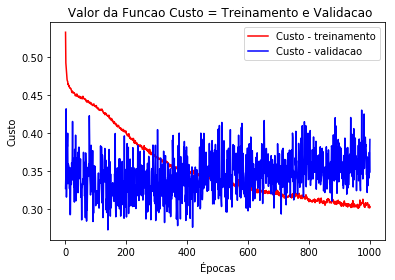

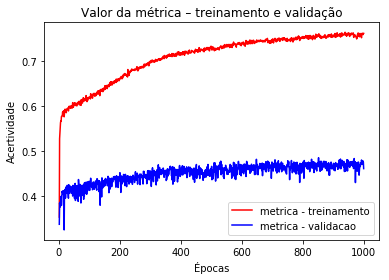

In [27]:
rna2.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna2.plot()

Confusion matrix, without normalization
[[15275  2662]
 [  470  1593]]


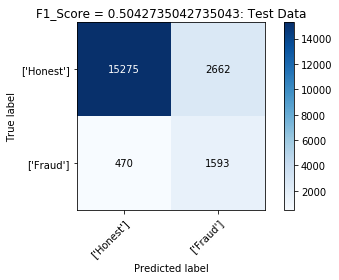

Confusion matrix, without normalization
[[15138  2844]
 [  424  1594]]


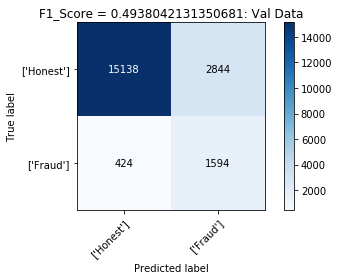

Confusion matrix, without normalization
[[40895  4080]
 [ 4489 15609]]


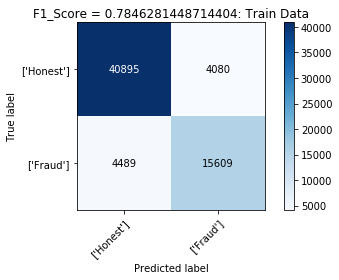

In [28]:
rna2.predict(x_data,y_data)

In [29]:
n_list3 = [100,100,1]
activation_list3 = ['tanh', 'tanh', 'sigmoid']

In [30]:
rna3 = new_rna()
rna3.build_model(data_shape,n_list3,activation_list3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.5242 - f1: 0.4035 - val_loss: 0.3939 - val_f1: 0.3837
Epoch 2/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4859 - f1: 0.5339 - val_loss: 0.3418 - val_f1: 0.3825
Epoch 3/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4795 - f1: 0.5483 - val_loss: 0.3259 - val_f1: 0.3848
Epoch 4/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4757 - f1: 0.5585 - val_loss: 0.3641 - val_f1: 0.3979
Epoch 5/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4723 - f1: 0.5629 - val_loss: 0.3606 - val_f1: 0.3926
Epoch 6/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4701 - f1: 0.5654 - val_loss: 0.3597 - val_f1: 0.4024
Epoch 7/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4692 - f1: 0.5657 - val_loss: 0.3050 - val_f1

65073/65073 [==============================] - 2s 38us/step - loss: 0.4394 - f1: 0.6157 - val_loss: 0.3318 - val_f1: 0.4271
Epoch 61/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4398 - f1: 0.6114 - val_loss: 0.3563 - val_f1: 0.4247
Epoch 62/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.4417 - f1: 0.6102 - val_loss: 0.3072 - val_f1: 0.4260
Epoch 63/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4403 - f1: 0.6079 - val_loss: 0.3632 - val_f1: 0.4165
Epoch 64/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4391 - f1: 0.6108 - val_loss: 0.3183 - val_f1: 0.4351
Epoch 65/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4383 - f1: 0.6155 - val_loss: 0.3186 - val_f1: 0.4198
Epoch 66/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4400 - f1: 0.6117 - val_loss: 0.3277 - val_f1: 0.4251
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 2s 38us/step - loss: 0.4123 - f1: 0.6487 - val_loss: 0.3488 - val_f1: 0.4286
Epoch 120/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4128 - f1: 0.6483 - val_loss: 0.3221 - val_f1: 0.4408
Epoch 121/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4136 - f1: 0.6465 - val_loss: 0.3632 - val_f1: 0.4416
Epoch 122/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4128 - f1: 0.6461 - val_loss: 0.3171 - val_f1: 0.4470
Epoch 123/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4115 - f1: 0.6499 - val_loss: 0.3574 - val_f1: 0.4302
Epoch 124/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4098 - f1: 0.6498 - val_loss: 0.3338 - val_f1: 0.4311
Epoch 125/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4117 - f1: 0.6451 - val_loss: 0.3120 - val_f1: 0.4535
Epoch 126/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.3792 - f1: 0.6848 - val_loss: 0.2916 - val_f1: 0.4495
Epoch 179/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3792 - f1: 0.6814 - val_loss: 0.3193 - val_f1: 0.4507
Epoch 180/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3799 - f1: 0.6829 - val_loss: 0.3514 - val_f1: 0.4485
Epoch 181/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3753 - f1: 0.6900 - val_loss: 0.2998 - val_f1: 0.4518
Epoch 182/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.3791 - f1: 0.6862 - val_loss: 0.2929 - val_f1: 0.4638
Epoch 183/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3779 - f1: 0.6860 - val_loss: 0.3291 - val_f1: 0.4582
Epoch 184/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3763 - f1: 0.6877 - val_loss: 0.3798 - val_f1: 0.4412
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3459 - f1: 0.7238 - val_loss: 0.3703 - val_f1: 0.4457
Epoch 238/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3436 - f1: 0.7222 - val_loss: 0.2899 - val_f1: 0.4375
Epoch 239/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3443 - f1: 0.7203 - val_loss: 0.3212 - val_f1: 0.4660
Epoch 240/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3473 - f1: 0.7190 - val_loss: 0.3029 - val_f1: 0.4675
Epoch 241/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3444 - f1: 0.7218 - val_loss: 0.3661 - val_f1: 0.4472
Epoch 242/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3433 - f1: 0.7250 - val_loss: 0.3510 - val_f1: 0.4561
Epoch 243/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3434 - f1: 0.7231 - val_loss: 0.3237 - val_f1: 0.4606
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.3211 - f1: 0.7454 - val_loss: 0.3697 - val_f1: 0.4631
Epoch 297/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3244 - f1: 0.7409 - val_loss: 0.3560 - val_f1: 0.4671
Epoch 298/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3207 - f1: 0.7473 - val_loss: 0.3344 - val_f1: 0.4698
Epoch 299/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3224 - f1: 0.7444 - val_loss: 0.3367 - val_f1: 0.4752
Epoch 300/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3254 - f1: 0.7398 - val_loss: 0.4177 - val_f1: 0.4495
Epoch 301/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3202 - f1: 0.7472 - val_loss: 0.3400 - val_f1: 0.4768
Epoch 302/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3205 - f1: 0.7466 - val_loss: 0.3095 - val_f1: 0.4839
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.3017 - f1: 0.7628 - val_loss: 0.3512 - val_f1: 0.4550
Epoch 356/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3003 - f1: 0.7668 - val_loss: 0.3507 - val_f1: 0.4804
Epoch 357/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3025 - f1: 0.7649 - val_loss: 0.3104 - val_f1: 0.4971
Epoch 358/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3010 - f1: 0.7628 - val_loss: 0.3242 - val_f1: 0.4906
Epoch 359/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2992 - f1: 0.7665 - val_loss: 0.3720 - val_f1: 0.4732
Epoch 360/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2978 - f1: 0.7651 - val_loss: 0.3410 - val_f1: 0.4788
Epoch 361/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2986 - f1: 0.7644 - val_loss: 0.4140 - val_f1: 0.4569
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.2847 - f1: 0.7787 - val_loss: 0.2966 - val_f1: 0.5086
Epoch 415/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2849 - f1: 0.7760 - val_loss: 0.3117 - val_f1: 0.5029
Epoch 416/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2836 - f1: 0.7800 - val_loss: 0.3513 - val_f1: 0.4801
Epoch 417/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.2853 - f1: 0.7773 - val_loss: 0.3209 - val_f1: 0.4951
Epoch 418/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2867 - f1: 0.7763 - val_loss: 0.3572 - val_f1: 0.4906
Epoch 419/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2823 - f1: 0.7819 - val_loss: 0.3783 - val_f1: 0.4755
Epoch 420/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2823 - f1: 0.7815 - val_loss: 0.3540 - val_f1: 0.4971
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.2712 - f1: 0.7940 - val_loss: 0.4290 - val_f1: 0.4618
Epoch 474/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2736 - f1: 0.7883 - val_loss: 0.3171 - val_f1: 0.4997
Epoch 475/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2719 - f1: 0.7908 - val_loss: 0.3947 - val_f1: 0.4856
Epoch 476/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2675 - f1: 0.7958 - val_loss: 0.4522 - val_f1: 0.4546
Epoch 477/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2717 - f1: 0.7902 - val_loss: 0.3742 - val_f1: 0.4769
Epoch 478/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.2718 - f1: 0.7932 - val_loss: 0.4407 - val_f1: 0.4543
Epoch 479/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2714 - f1: 0.7913 - val_loss: 0.3585 - val_f1: 0.4909
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.2616 - f1: 0.8017 - val_loss: 0.3292 - val_f1: 0.4993
Epoch 533/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.2586 - f1: 0.8009 - val_loss: 0.3493 - val_f1: 0.5031
Epoch 534/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2606 - f1: 0.8031 - val_loss: 0.3665 - val_f1: 0.4985
Epoch 535/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.2577 - f1: 0.8033 - val_loss: 0.3833 - val_f1: 0.4950
Epoch 536/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.2589 - f1: 0.8031 - val_loss: 0.3335 - val_f1: 0.5061
Epoch 537/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2601 - f1: 0.8013 - val_loss: 0.3838 - val_f1: 0.4885
Epoch 538/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2640 - f1: 0.7995 - val_loss: 0.2986 - val_f1: 0.4918
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2505 - f1: 0.8091 - val_loss: 0.3688 - val_f1: 0.4900
Epoch 592/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2549 - f1: 0.8050 - val_loss: 0.3837 - val_f1: 0.4885
Epoch 593/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2480 - f1: 0.8094 - val_loss: 0.4169 - val_f1: 0.4769
Epoch 594/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2496 - f1: 0.8114 - val_loss: 0.4544 - val_f1: 0.4677
Epoch 595/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2527 - f1: 0.8086 - val_loss: 0.4527 - val_f1: 0.4641
Epoch 596/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2514 - f1: 0.8102 - val_loss: 0.4397 - val_f1: 0.4775
Epoch 597/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2507 - f1: 0.8106 - val_loss: 0.3680 - val_f1: 0.4851
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 39us/step - loss: 0.2445 - f1: 0.8182 - val_loss: 0.3971 - val_f1: 0.4813
Epoch 651/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2458 - f1: 0.8161 - val_loss: 0.3472 - val_f1: 0.5098
Epoch 652/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2411 - f1: 0.8199 - val_loss: 0.3754 - val_f1: 0.5028
Epoch 653/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2410 - f1: 0.8193 - val_loss: 0.3905 - val_f1: 0.4970
Epoch 654/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.2422 - f1: 0.8186 - val_loss: 0.3592 - val_f1: 0.5087
Epoch 655/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2353 - f1: 0.8238 - val_loss: 0.3758 - val_f1: 0.4935
Epoch 656/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2367 - f1: 0.8227 - val_loss: 0.3379 - val_f1: 0.5112
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.2322 - f1: 0.8270 - val_loss: 0.3927 - val_f1: 0.4932
Epoch 710/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2353 - f1: 0.8236 - val_loss: 0.3628 - val_f1: 0.5049
Epoch 711/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2367 - f1: 0.8196 - val_loss: 0.3754 - val_f1: 0.4992
Epoch 712/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2360 - f1: 0.8226 - val_loss: 0.3751 - val_f1: 0.5026
Epoch 713/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2369 - f1: 0.8209 - val_loss: 0.3702 - val_f1: 0.5154
Epoch 714/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2352 - f1: 0.8232 - val_loss: 0.3289 - val_f1: 0.5134
Epoch 715/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2387 - f1: 0.8196 - val_loss: 0.4002 - val_f1: 0.5000
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.2277 - f1: 0.8313 - val_loss: 0.3532 - val_f1: 0.5158
Epoch 769/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2255 - f1: 0.8353 - val_loss: 0.4484 - val_f1: 0.4890
Epoch 770/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2271 - f1: 0.8316 - val_loss: 0.3874 - val_f1: 0.5010
Epoch 771/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2344 - f1: 0.8286 - val_loss: 0.4135 - val_f1: 0.5021
Epoch 772/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.2328 - f1: 0.8244 - val_loss: 0.4161 - val_f1: 0.4864
Epoch 773/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2320 - f1: 0.8274 - val_loss: 0.4155 - val_f1: 0.4862
Epoch 774/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2289 - f1: 0.8294 - val_loss: 0.4336 - val_f1: 0.4980
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.2179 - f1: 0.8396 - val_loss: 0.4146 - val_f1: 0.4947
Epoch 828/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2185 - f1: 0.8397 - val_loss: 0.3902 - val_f1: 0.5085
Epoch 829/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2272 - f1: 0.8314 - val_loss: 0.4315 - val_f1: 0.4993
Epoch 830/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.2237 - f1: 0.8351 - val_loss: 0.4120 - val_f1: 0.5066
Epoch 831/1000
65073/65073 [==============================] - 3s 38us/step - loss: 0.2249 - f1: 0.8332 - val_loss: 0.4353 - val_f1: 0.5009
Epoch 832/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2209 - f1: 0.8352 - val_loss: 0.4012 - val_f1: 0.5058
Epoch 833/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2224 - f1: 0.8343 - val_loss: 0.4067 - val_f1: 0.5020
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.2156 - f1: 0.8394 - val_loss: 0.4447 - val_f1: 0.4976
Epoch 887/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2168 - f1: 0.8412 - val_loss: 0.4477 - val_f1: 0.5000
Epoch 888/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2163 - f1: 0.8415 - val_loss: 0.3767 - val_f1: 0.5116
Epoch 889/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2225 - f1: 0.8356 - val_loss: 0.4394 - val_f1: 0.4939
Epoch 890/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2299 - f1: 0.8300 - val_loss: 0.4229 - val_f1: 0.5018
Epoch 891/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2236 - f1: 0.8341 - val_loss: 0.3969 - val_f1: 0.4844
Epoch 892/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2195 - f1: 0.8369 - val_loss: 0.4807 - val_f1: 0.4717
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.2144 - f1: 0.8403 - val_loss: 0.4728 - val_f1: 0.4921
Epoch 946/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2132 - f1: 0.8422 - val_loss: 0.3878 - val_f1: 0.5146
Epoch 947/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2130 - f1: 0.8394 - val_loss: 0.5046 - val_f1: 0.4947
Epoch 948/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.2200 - f1: 0.8353 - val_loss: 0.3848 - val_f1: 0.5029
Epoch 949/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2209 - f1: 0.8349 - val_loss: 0.4079 - val_f1: 0.5050
Epoch 950/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2174 - f1: 0.8413 - val_loss: 0.3957 - val_f1: 0.5003
Epoch 951/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2212 - f1: 0.8342 - val_loss: 0.4178 - val_f1: 0.5068
Epoch 952/1000
65073/65073 [==============

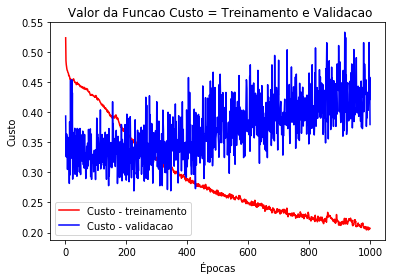

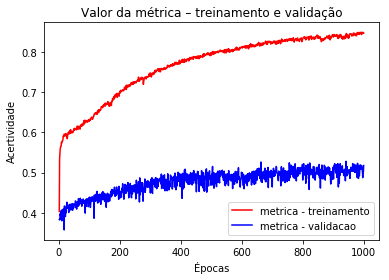

In [31]:
rna3.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna3.plot()

Confusion matrix, without normalization
[[15744  2193]
 [  420  1643]]


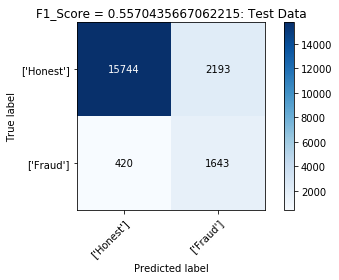

Confusion matrix, without normalization
[[15855  2127]
 [  418  1600]]


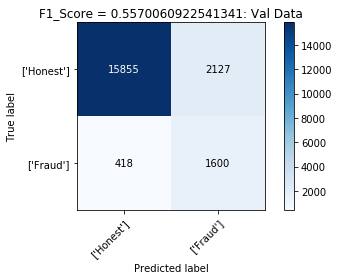

Confusion matrix, without normalization
[[43539  1436]
 [ 4231 15867]]


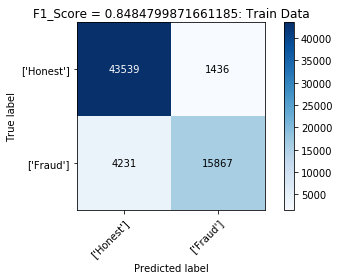

In [32]:
rna3.predict(x_data,y_data)

In [33]:
n_list4 = [50,50,50,1]
activation_list4 = ['tanh','tanh','tanh','sigmoid']

In [34]:
rna4 = new_rna()
rna4.build_model(data_shape,n_list4,activation_list4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 15,201
Trainable params: 15,201
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.5323 - f1: 0.3839 - val_loss: 0.3547 - val_f1: 0.3636
Epoch 2/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4939 - f1: 0.5230 - val_loss: 0.3927 - val_f1: 0.3803
Epoch 3/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4857 - f1: 0.5444 - val_loss: 0.3811 - val_f1: 0.3772
Epoch 4/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4788 - f1: 0.5601 - val_loss: 0.3469 - val_f1: 0.3905
Epoch 5/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4728 - f1: 0.5644 - val_loss: 0.3564 - val_f1: 0.4046
Epoch 6/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4713 - f1: 0.5682 - val_loss: 0.3544 - val_f1: 0.4074
Epoch 7/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4699 - f1: 0.5680 - val_loss: 0.3195 - val_f1

65073/65073 [==============================] - 2s 37us/step - loss: 0.4428 - f1: 0.6089 - val_loss: 0.3125 - val_f1: 0.4255
Epoch 61/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4430 - f1: 0.6089 - val_loss: 0.3161 - val_f1: 0.4084
Epoch 62/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4431 - f1: 0.6059 - val_loss: 0.3080 - val_f1: 0.4186
Epoch 63/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4447 - f1: 0.6036 - val_loss: 0.3399 - val_f1: 0.4110
Epoch 64/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.4444 - f1: 0.6034 - val_loss: 0.3009 - val_f1: 0.4264
Epoch 65/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4440 - f1: 0.6059 - val_loss: 0.3045 - val_f1: 0.4313
Epoch 66/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4433 - f1: 0.6078 - val_loss: 0.3102 - val_f1: 0.4268
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 2s 37us/step - loss: 0.4352 - f1: 0.6197 - val_loss: 0.3664 - val_f1: 0.4131
Epoch 120/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4341 - f1: 0.6191 - val_loss: 0.3246 - val_f1: 0.4385
Epoch 121/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4345 - f1: 0.6195 - val_loss: 0.3541 - val_f1: 0.4214
Epoch 122/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4338 - f1: 0.6199 - val_loss: 0.3778 - val_f1: 0.4116
Epoch 123/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4357 - f1: 0.6151 - val_loss: 0.3032 - val_f1: 0.4320
Epoch 124/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4341 - f1: 0.6182 - val_loss: 0.3291 - val_f1: 0.4282
Epoch 125/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4328 - f1: 0.6176 - val_loss: 0.3355 - val_f1: 0.4284
Epoch 126/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.4240 - f1: 0.6293 - val_loss: 0.3595 - val_f1: 0.4263
Epoch 179/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4229 - f1: 0.6327 - val_loss: 0.3804 - val_f1: 0.4164
Epoch 180/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4214 - f1: 0.6311 - val_loss: 0.3178 - val_f1: 0.4359
Epoch 181/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4237 - f1: 0.6312 - val_loss: 0.3470 - val_f1: 0.4196
Epoch 182/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4225 - f1: 0.6329 - val_loss: 0.3686 - val_f1: 0.4293
Epoch 183/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4215 - f1: 0.6321 - val_loss: 0.3348 - val_f1: 0.4251
Epoch 184/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4207 - f1: 0.6362 - val_loss: 0.3229 - val_f1: 0.4360
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.4120 - f1: 0.6410 - val_loss: 0.2955 - val_f1: 0.4278
Epoch 238/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4094 - f1: 0.6442 - val_loss: 0.3283 - val_f1: 0.4420
Epoch 239/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4072 - f1: 0.6513 - val_loss: 0.3192 - val_f1: 0.4374
Epoch 240/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4086 - f1: 0.6514 - val_loss: 0.3211 - val_f1: 0.4435
Epoch 241/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4069 - f1: 0.6461 - val_loss: 0.3265 - val_f1: 0.4360
Epoch 242/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4075 - f1: 0.6497 - val_loss: 0.3283 - val_f1: 0.4377
Epoch 243/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4085 - f1: 0.6476 - val_loss: 0.3272 - val_f1: 0.4448
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.3910 - f1: 0.6711 - val_loss: 0.3004 - val_f1: 0.4438
Epoch 297/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3917 - f1: 0.6689 - val_loss: 0.2960 - val_f1: 0.4511
Epoch 298/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3946 - f1: 0.6635 - val_loss: 0.3528 - val_f1: 0.4356
Epoch 299/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3936 - f1: 0.6636 - val_loss: 0.2932 - val_f1: 0.4305
Epoch 300/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3938 - f1: 0.6661 - val_loss: 0.3947 - val_f1: 0.4296
Epoch 301/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3954 - f1: 0.6609 - val_loss: 0.3832 - val_f1: 0.4401
Epoch 302/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3936 - f1: 0.6624 - val_loss: 0.3122 - val_f1: 0.4573
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.3854 - f1: 0.6745 - val_loss: 0.3428 - val_f1: 0.4426
Epoch 356/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3870 - f1: 0.6701 - val_loss: 0.3467 - val_f1: 0.4509
Epoch 357/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3857 - f1: 0.6773 - val_loss: 0.2915 - val_f1: 0.4493
Epoch 358/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3841 - f1: 0.6732 - val_loss: 0.3493 - val_f1: 0.4469
Epoch 359/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3867 - f1: 0.6739 - val_loss: 0.3214 - val_f1: 0.4531
Epoch 360/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3831 - f1: 0.6771 - val_loss: 0.3123 - val_f1: 0.4489
Epoch 361/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.3848 - f1: 0.6752 - val_loss: 0.3309 - val_f1: 0.4456
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3767 - f1: 0.6827 - val_loss: 0.3392 - val_f1: 0.4545
Epoch 415/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3736 - f1: 0.6852 - val_loss: 0.3705 - val_f1: 0.4245
Epoch 416/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3733 - f1: 0.6851 - val_loss: 0.3001 - val_f1: 0.4528
Epoch 417/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3740 - f1: 0.6883 - val_loss: 0.3478 - val_f1: 0.4539
Epoch 418/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3727 - f1: 0.6865 - val_loss: 0.3697 - val_f1: 0.4456
Epoch 419/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3714 - f1: 0.6839 - val_loss: 0.3223 - val_f1: 0.4527
Epoch 420/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3710 - f1: 0.6903 - val_loss: 0.3095 - val_f1: 0.4600
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3654 - f1: 0.6931 - val_loss: 0.3064 - val_f1: 0.4629
Epoch 474/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3652 - f1: 0.6964 - val_loss: 0.3455 - val_f1: 0.4458
Epoch 475/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3655 - f1: 0.6952 - val_loss: 0.3766 - val_f1: 0.4436
Epoch 476/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3650 - f1: 0.6950 - val_loss: 0.3199 - val_f1: 0.4545
Epoch 477/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3654 - f1: 0.6950 - val_loss: 0.3478 - val_f1: 0.4566
Epoch 478/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3623 - f1: 0.6957 - val_loss: 0.3367 - val_f1: 0.4504
Epoch 479/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3654 - f1: 0.6915 - val_loss: 0.3432 - val_f1: 0.4487
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3596 - f1: 0.7005 - val_loss: 0.3731 - val_f1: 0.4445
Epoch 533/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3598 - f1: 0.6996 - val_loss: 0.3455 - val_f1: 0.4488
Epoch 534/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3619 - f1: 0.6986 - val_loss: 0.3932 - val_f1: 0.4477
Epoch 535/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3591 - f1: 0.7048 - val_loss: 0.3293 - val_f1: 0.4669
Epoch 536/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3589 - f1: 0.7017 - val_loss: 0.3560 - val_f1: 0.4556
Epoch 537/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3588 - f1: 0.7045 - val_loss: 0.3156 - val_f1: 0.4598
Epoch 538/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3588 - f1: 0.7032 - val_loss: 0.3419 - val_f1: 0.4642
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3503 - f1: 0.7078 - val_loss: 0.3383 - val_f1: 0.4657
Epoch 592/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3529 - f1: 0.7071 - val_loss: 0.3289 - val_f1: 0.4618
Epoch 593/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3530 - f1: 0.7030 - val_loss: 0.2973 - val_f1: 0.4619
Epoch 594/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3516 - f1: 0.7065 - val_loss: 0.3767 - val_f1: 0.4363
Epoch 595/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3528 - f1: 0.7071 - val_loss: 0.2873 - val_f1: 0.4701
Epoch 596/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3508 - f1: 0.7108 - val_loss: 0.3506 - val_f1: 0.4696
Epoch 597/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3511 - f1: 0.7097 - val_loss: 0.3286 - val_f1: 0.4628
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3481 - f1: 0.7095 - val_loss: 0.3468 - val_f1: 0.4573
Epoch 651/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3518 - f1: 0.7046 - val_loss: 0.3722 - val_f1: 0.4602
Epoch 652/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3493 - f1: 0.7054 - val_loss: 0.3475 - val_f1: 0.4648
Epoch 653/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3501 - f1: 0.7085 - val_loss: 0.3700 - val_f1: 0.4590
Epoch 654/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3485 - f1: 0.7095 - val_loss: 0.3187 - val_f1: 0.4536
Epoch 655/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3474 - f1: 0.7112 - val_loss: 0.3010 - val_f1: 0.4634
Epoch 656/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3490 - f1: 0.7094 - val_loss: 0.3465 - val_f1: 0.4518
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.3462 - f1: 0.7100 - val_loss: 0.3255 - val_f1: 0.4651
Epoch 710/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3444 - f1: 0.7143 - val_loss: 0.3512 - val_f1: 0.4647
Epoch 711/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3452 - f1: 0.7155 - val_loss: 0.3133 - val_f1: 0.4500
Epoch 712/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3453 - f1: 0.7123 - val_loss: 0.3324 - val_f1: 0.4576
Epoch 713/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3428 - f1: 0.7156 - val_loss: 0.3292 - val_f1: 0.4518
Epoch 714/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3444 - f1: 0.7121 - val_loss: 0.3060 - val_f1: 0.4686
Epoch 715/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3467 - f1: 0.7105 - val_loss: 0.3595 - val_f1: 0.4542
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.3476 - f1: 0.7116 - val_loss: 0.3322 - val_f1: 0.4598
Epoch 769/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3481 - f1: 0.7087 - val_loss: 0.3364 - val_f1: 0.4668
Epoch 770/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3471 - f1: 0.7141 - val_loss: 0.3386 - val_f1: 0.4601
Epoch 771/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3489 - f1: 0.7088 - val_loss: 0.3558 - val_f1: 0.4592
Epoch 772/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.3471 - f1: 0.7074 - val_loss: 0.3242 - val_f1: 0.4643
Epoch 773/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.3479 - f1: 0.7048 - val_loss: 0.3542 - val_f1: 0.4669
Epoch 774/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3455 - f1: 0.7132 - val_loss: 0.3887 - val_f1: 0.4515
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3415 - f1: 0.7166 - val_loss: 0.3609 - val_f1: 0.4625
Epoch 828/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3406 - f1: 0.7172 - val_loss: 0.3394 - val_f1: 0.4715
Epoch 829/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3395 - f1: 0.7188 - val_loss: 0.3536 - val_f1: 0.4663
Epoch 830/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3405 - f1: 0.7170 - val_loss: 0.3198 - val_f1: 0.4703
Epoch 831/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3397 - f1: 0.7180 - val_loss: 0.3364 - val_f1: 0.4655
Epoch 832/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3399 - f1: 0.7128 - val_loss: 0.3849 - val_f1: 0.4614
Epoch 833/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3407 - f1: 0.7163 - val_loss: 0.3917 - val_f1: 0.4194
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.3358 - f1: 0.7191 - val_loss: 0.3699 - val_f1: 0.4710
Epoch 887/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3337 - f1: 0.7209 - val_loss: 0.3666 - val_f1: 0.4595
Epoch 888/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3347 - f1: 0.7206 - val_loss: 0.3610 - val_f1: 0.4695
Epoch 889/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3342 - f1: 0.7214 - val_loss: 0.3594 - val_f1: 0.4554
Epoch 890/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3374 - f1: 0.7176 - val_loss: 0.3638 - val_f1: 0.4618
Epoch 891/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3350 - f1: 0.7216 - val_loss: 0.3001 - val_f1: 0.4690
Epoch 892/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3364 - f1: 0.7210 - val_loss: 0.3433 - val_f1: 0.4594
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3389 - f1: 0.7164 - val_loss: 0.3244 - val_f1: 0.4643
Epoch 946/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3375 - f1: 0.7154 - val_loss: 0.2923 - val_f1: 0.4595
Epoch 947/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3355 - f1: 0.7225 - val_loss: 0.3202 - val_f1: 0.4723
Epoch 948/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3355 - f1: 0.7230 - val_loss: 0.3746 - val_f1: 0.4537
Epoch 949/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3358 - f1: 0.7197 - val_loss: 0.3245 - val_f1: 0.4620
Epoch 950/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3366 - f1: 0.7189 - val_loss: 0.3158 - val_f1: 0.4609
Epoch 951/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3363 - f1: 0.7180 - val_loss: 0.3349 - val_f1: 0.4624
Epoch 952/1000
65073/65073 [==============

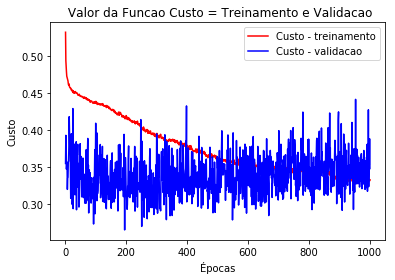

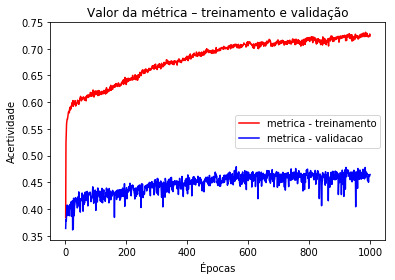

In [35]:
rna4.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna4.plot()

Confusion matrix, without normalization
[[15925  2012]
 [  692  1371]]


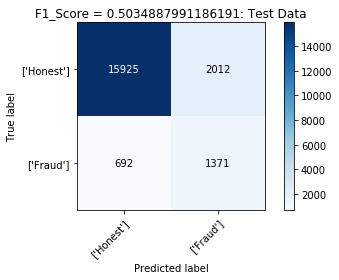

Confusion matrix, without normalization
[[15860  2122]
 [  623  1395]]


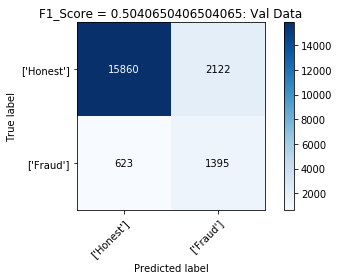

Confusion matrix, without normalization
[[41616  3359]
 [ 6576 13522]]


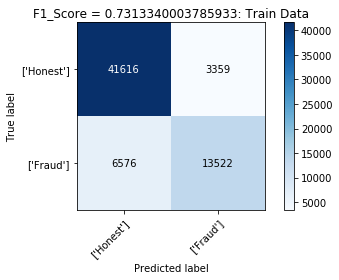

In [36]:
rna4.predict(x_data,y_data)

In [37]:
n_list5 = [100,100,100,1]
activation_list5 = ['tanh','tanh','tanh','sigmoid']

In [38]:
rna5 = new_rna()
rna5.build_model(data_shape,n_list5,activation_list5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 40,401
Trainable params: 40,401
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.5247 - f1: 0.4108 - val_loss: 0.3761 - val_f1: 0.3586
Epoch 2/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4880 - f1: 0.5316 - val_loss: 0.3457 - val_f1: 0.3777
Epoch 3/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4810 - f1: 0.5463 - val_loss: 0.3623 - val_f1: 0.3974
Epoch 4/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4768 - f1: 0.5566 - val_loss: 0.3553 - val_f1: 0.3850
Epoch 5/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4747 - f1: 0.5634 - val_loss: 0.3401 - val_f1: 0.4045
Epoch 6/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4724 - f1: 0.5617 - val_loss: 0.3604 - val_f1: 0.3893
Epoch 7/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4694 - f1: 0.5690 - val_loss: 0.3405 - val_f1

65073/65073 [==============================] - 3s 41us/step - loss: 0.4399 - f1: 0.6121 - val_loss: 0.3594 - val_f1: 0.4301
Epoch 61/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4401 - f1: 0.6147 - val_loss: 0.3545 - val_f1: 0.4244
Epoch 62/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4409 - f1: 0.6081 - val_loss: 0.3437 - val_f1: 0.4191
Epoch 63/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4416 - f1: 0.6071 - val_loss: 0.3070 - val_f1: 0.4078
Epoch 64/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4409 - f1: 0.6104 - val_loss: 0.3798 - val_f1: 0.4031
Epoch 65/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4410 - f1: 0.6118 - val_loss: 0.3243 - val_f1: 0.4278
Epoch 66/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4427 - f1: 0.6101 - val_loss: 0.3210 - val_f1: 0.4227
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 3s 41us/step - loss: 0.4227 - f1: 0.6313 - val_loss: 0.3836 - val_f1: 0.4346
Epoch 120/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4218 - f1: 0.6345 - val_loss: 0.3192 - val_f1: 0.4346
Epoch 121/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4211 - f1: 0.6298 - val_loss: 0.3270 - val_f1: 0.4233
Epoch 122/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4224 - f1: 0.6326 - val_loss: 0.3571 - val_f1: 0.4233
Epoch 123/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4180 - f1: 0.6385 - val_loss: 0.3117 - val_f1: 0.4310
Epoch 124/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4168 - f1: 0.6376 - val_loss: 0.3170 - val_f1: 0.4268
Epoch 125/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4189 - f1: 0.6373 - val_loss: 0.3084 - val_f1: 0.4327
Epoch 126/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.3881 - f1: 0.6758 - val_loss: 0.3253 - val_f1: 0.4520
Epoch 179/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3870 - f1: 0.6752 - val_loss: 0.3309 - val_f1: 0.4539
Epoch 180/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3877 - f1: 0.6786 - val_loss: 0.3011 - val_f1: 0.4401
Epoch 181/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3877 - f1: 0.6751 - val_loss: 0.4046 - val_f1: 0.4387
Epoch 182/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3852 - f1: 0.6776 - val_loss: 0.3853 - val_f1: 0.4305
Epoch 183/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3843 - f1: 0.6797 - val_loss: 0.3143 - val_f1: 0.4489
Epoch 184/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.3842 - f1: 0.6777 - val_loss: 0.3203 - val_f1: 0.4444
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.3527 - f1: 0.7109 - val_loss: 0.3650 - val_f1: 0.4519
Epoch 238/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3502 - f1: 0.7151 - val_loss: 0.3472 - val_f1: 0.4514
Epoch 239/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3533 - f1: 0.7097 - val_loss: 0.3278 - val_f1: 0.4610
Epoch 240/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.3511 - f1: 0.7105 - val_loss: 0.3108 - val_f1: 0.4502
Epoch 241/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3513 - f1: 0.7105 - val_loss: 0.3123 - val_f1: 0.4570
Epoch 242/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3518 - f1: 0.7150 - val_loss: 0.3120 - val_f1: 0.4491
Epoch 243/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.3513 - f1: 0.7138 - val_loss: 0.3061 - val_f1: 0.4685
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.3233 - f1: 0.7414 - val_loss: 0.3459 - val_f1: 0.4616
Epoch 297/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3227 - f1: 0.7453 - val_loss: 0.3274 - val_f1: 0.4737
Epoch 298/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3237 - f1: 0.7386 - val_loss: 0.3273 - val_f1: 0.4707
Epoch 299/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3241 - f1: 0.7397 - val_loss: 0.3163 - val_f1: 0.4668
Epoch 300/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3247 - f1: 0.7394 - val_loss: 0.3884 - val_f1: 0.4571
Epoch 301/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3194 - f1: 0.7464 - val_loss: 0.2905 - val_f1: 0.4609
Epoch 302/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.3242 - f1: 0.7390 - val_loss: 0.3405 - val_f1: 0.4730
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 43us/step - loss: 0.2978 - f1: 0.7653 - val_loss: 0.3809 - val_f1: 0.4559
Epoch 356/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3020 - f1: 0.7640 - val_loss: 0.3447 - val_f1: 0.4672
Epoch 357/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3009 - f1: 0.7639 - val_loss: 0.3840 - val_f1: 0.4603
Epoch 358/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2997 - f1: 0.7599 - val_loss: 0.3474 - val_f1: 0.4696
Epoch 359/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2967 - f1: 0.7674 - val_loss: 0.4495 - val_f1: 0.4371
Epoch 360/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3004 - f1: 0.7640 - val_loss: 0.3677 - val_f1: 0.4714
Epoch 361/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2996 - f1: 0.7627 - val_loss: 0.3826 - val_f1: 0.4631
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.2801 - f1: 0.7831 - val_loss: 0.3780 - val_f1: 0.4741
Epoch 415/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2876 - f1: 0.7762 - val_loss: 0.4151 - val_f1: 0.4566
Epoch 416/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2883 - f1: 0.7741 - val_loss: 0.3457 - val_f1: 0.4760
Epoch 417/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2825 - f1: 0.7801 - val_loss: 0.3748 - val_f1: 0.4829
Epoch 418/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2810 - f1: 0.7802 - val_loss: 0.3639 - val_f1: 0.4754
Epoch 419/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2828 - f1: 0.7784 - val_loss: 0.3601 - val_f1: 0.4845
Epoch 420/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2799 - f1: 0.7817 - val_loss: 0.3352 - val_f1: 0.4785
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2686 - f1: 0.7946 - val_loss: 0.3443 - val_f1: 0.4909
Epoch 474/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2693 - f1: 0.7926 - val_loss: 0.4297 - val_f1: 0.4481
Epoch 475/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.2636 - f1: 0.7982 - val_loss: 0.4057 - val_f1: 0.4764
Epoch 476/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2660 - f1: 0.7953 - val_loss: 0.3765 - val_f1: 0.4868
Epoch 477/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2687 - f1: 0.7930 - val_loss: 0.4056 - val_f1: 0.4751
Epoch 478/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2629 - f1: 0.7934 - val_loss: 0.3424 - val_f1: 0.4702
Epoch 479/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2693 - f1: 0.7929 - val_loss: 0.3754 - val_f1: 0.4826
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2510 - f1: 0.8057 - val_loss: 0.4212 - val_f1: 0.4881
Epoch 533/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2519 - f1: 0.8070 - val_loss: 0.4081 - val_f1: 0.4863
Epoch 534/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2506 - f1: 0.8086 - val_loss: 0.4448 - val_f1: 0.4647
Epoch 535/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2455 - f1: 0.8151 - val_loss: 0.4035 - val_f1: 0.4957
Epoch 536/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2506 - f1: 0.8105 - val_loss: 0.4747 - val_f1: 0.4545
Epoch 537/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2526 - f1: 0.8084 - val_loss: 0.3863 - val_f1: 0.4930
Epoch 538/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2462 - f1: 0.8161 - val_loss: 0.3402 - val_f1: 0.5059
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2400 - f1: 0.8164 - val_loss: 0.3994 - val_f1: 0.4870
Epoch 592/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2431 - f1: 0.8118 - val_loss: 0.3665 - val_f1: 0.5072
Epoch 593/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2406 - f1: 0.8160 - val_loss: 0.3800 - val_f1: 0.4972
Epoch 594/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2427 - f1: 0.8119 - val_loss: 0.3592 - val_f1: 0.5005
Epoch 595/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.2418 - f1: 0.8161 - val_loss: 0.3906 - val_f1: 0.4967
Epoch 596/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2418 - f1: 0.8169 - val_loss: 0.4017 - val_f1: 0.4917
Epoch 597/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2439 - f1: 0.8154 - val_loss: 0.4377 - val_f1: 0.4716
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2305 - f1: 0.8261 - val_loss: 0.3909 - val_f1: 0.4992
Epoch 651/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2300 - f1: 0.8290 - val_loss: 0.4592 - val_f1: 0.4821
Epoch 652/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.2356 - f1: 0.8217 - val_loss: 0.4667 - val_f1: 0.4791
Epoch 653/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2370 - f1: 0.8216 - val_loss: 0.4018 - val_f1: 0.4889
Epoch 654/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2355 - f1: 0.8206 - val_loss: 0.3518 - val_f1: 0.5001
Epoch 655/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2304 - f1: 0.8252 - val_loss: 0.5027 - val_f1: 0.4655
Epoch 656/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2297 - f1: 0.8257 - val_loss: 0.4168 - val_f1: 0.4871
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2223 - f1: 0.8328 - val_loss: 0.3945 - val_f1: 0.5101
Epoch 710/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2249 - f1: 0.8321 - val_loss: 0.3869 - val_f1: 0.5031
Epoch 711/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2276 - f1: 0.8289 - val_loss: 0.4542 - val_f1: 0.4919
Epoch 712/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2272 - f1: 0.8273 - val_loss: 0.4263 - val_f1: 0.4926
Epoch 713/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2293 - f1: 0.8290 - val_loss: 0.3840 - val_f1: 0.5031
Epoch 714/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2236 - f1: 0.8330 - val_loss: 0.4565 - val_f1: 0.4953
Epoch 715/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2222 - f1: 0.8345 - val_loss: 0.3998 - val_f1: 0.5124
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2182 - f1: 0.8378 - val_loss: 0.4738 - val_f1: 0.4821
Epoch 769/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2191 - f1: 0.8354 - val_loss: 0.4390 - val_f1: 0.4927
Epoch 770/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2180 - f1: 0.8373 - val_loss: 0.4022 - val_f1: 0.5098
Epoch 771/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2216 - f1: 0.8332 - val_loss: 0.4440 - val_f1: 0.4891
Epoch 772/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2246 - f1: 0.8308 - val_loss: 0.4419 - val_f1: 0.4890
Epoch 773/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2227 - f1: 0.8308 - val_loss: 0.4419 - val_f1: 0.4887
Epoch 774/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2211 - f1: 0.8334 - val_loss: 0.4105 - val_f1: 0.4987
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2130 - f1: 0.8404 - val_loss: 0.4734 - val_f1: 0.4941
Epoch 828/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2131 - f1: 0.8390 - val_loss: 0.4103 - val_f1: 0.5076
Epoch 829/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2199 - f1: 0.8355 - val_loss: 0.4610 - val_f1: 0.4958
Epoch 830/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2183 - f1: 0.8370 - val_loss: 0.4630 - val_f1: 0.4893
Epoch 831/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2254 - f1: 0.8302 - val_loss: 0.4956 - val_f1: 0.4801
Epoch 832/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2221 - f1: 0.8338 - val_loss: 0.3839 - val_f1: 0.5186
Epoch 833/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2155 - f1: 0.8383 - val_loss: 0.4313 - val_f1: 0.5018
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2077 - f1: 0.8453 - val_loss: 0.4990 - val_f1: 0.4840
Epoch 887/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2097 - f1: 0.8437 - val_loss: 0.4698 - val_f1: 0.4944
Epoch 888/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2085 - f1: 0.8453 - val_loss: 0.4344 - val_f1: 0.5063
Epoch 889/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2156 - f1: 0.8383 - val_loss: 0.3591 - val_f1: 0.5266
Epoch 890/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2139 - f1: 0.8401 - val_loss: 0.4287 - val_f1: 0.5021
Epoch 891/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2229 - f1: 0.8318 - val_loss: 0.4420 - val_f1: 0.4981
Epoch 892/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2159 - f1: 0.8380 - val_loss: 0.3790 - val_f1: 0.5160
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 43us/step - loss: 0.2075 - f1: 0.8451 - val_loss: 0.4325 - val_f1: 0.5084
Epoch 946/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2085 - f1: 0.8435 - val_loss: 0.4814 - val_f1: 0.5026
Epoch 947/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2119 - f1: 0.8411 - val_loss: 0.4540 - val_f1: 0.4989
Epoch 948/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2064 - f1: 0.8463 - val_loss: 0.4851 - val_f1: 0.4998
Epoch 949/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.2032 - f1: 0.8471 - val_loss: 0.4749 - val_f1: 0.4968
Epoch 950/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2032 - f1: 0.8492 - val_loss: 0.4638 - val_f1: 0.5020
Epoch 951/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.2058 - f1: 0.8475 - val_loss: 0.4498 - val_f1: 0.5010
Epoch 952/1000
65073/65073 [==============

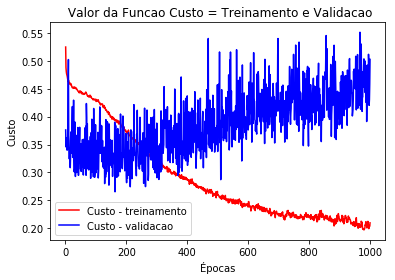

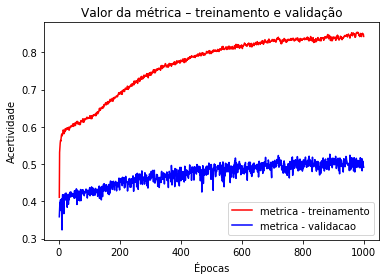

In [39]:
rna5.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna5.plot()

Confusion matrix, without normalization
[[15119  2818]
 [  322  1741]]


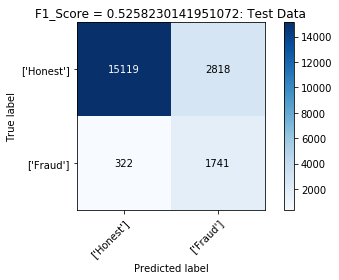

Confusion matrix, without normalization
[[15207  2775]
 [  313  1705]]


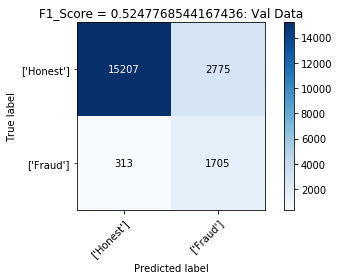

Confusion matrix, without normalization
[[42434  2541]
 [ 2883 17215]]


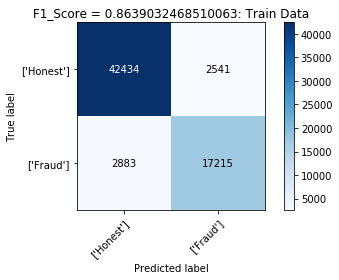

In [40]:
rna5.predict(x_data,y_data)

### Agora iremos utilizar a tecnica de regularizacao chamada dropout. Essa tecnica eh utilizada para combater o overffiting (diferenca consideravel entre a acertividade do modelo com os dados de treinamento e validacao/teste), nessa tecnica os neuronios sao "desligados" ao longo das epocas, para que os pesos da rede se ajustem de forma mais igualitaria.


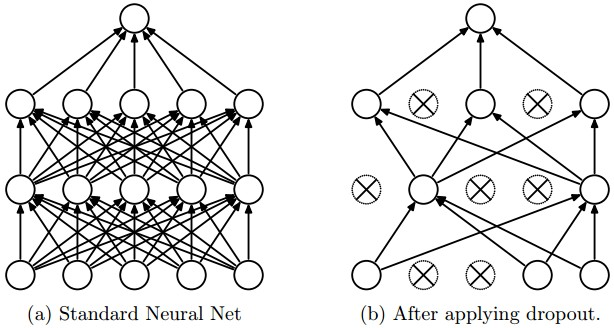


In [41]:
meanx = x_train.mean(axis = 0)
stdx = x_train.std(axis = 0)
x_train_norm = (x_train - meanx)/stdx
x_val_norm = (x_val - meanx)/stdx
x_test_norm = (x_test - meanx)/stdx
x_train_norm=np.asarray(x_train_norm)
x_test_norm=np.asarray(x_test_norm)
x_val_norm=np.asarray(x_val_norm)

In [42]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [43]:
class new_rna_droplist:
    def build_model(self,data_shape,units_list,activation_list,dropout_list):
        self.model = models.Sequential()
        if len(dropout_list)==0:
            my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
            for i in range(len(units_list)):
                if i == 0:
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i],
                                                kernel_initializer = my_init,
                                                input_shape=data_shape))
                else:
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i]))
        else:
            my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
            for i in range(len(units_list)):
                if i == 0:
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i], kernel_initializer = my_init,
                                                input_shape=data_shape,kernel_regularizer = regularizers.l2(0.01)))
                elif i < (len(units_list)-1):
                    self.model.add(layers.Dropout(dropout_list[i-1]))
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i],
                                               kernel_regularizer = regularizers.l2(0.001)))
                else:
                    self.model.add(layers.Dropout(dropout_list[i-1]))
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i]))
        self.model.summary()
           
    def train(self,x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric):
        mom = optimizers.SGD(lr=0.0005, decay=0, momentum=0.9, nesterov=True)
        self.model.compile(loss = [loss],metrics = [metric], optimizer = mom)
        history = self.model.fit(x_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (x_val,y_val))
        self.history_dict = history.history
        self.aux_train = 1
        
    def plot(self):
        if (self.aux_train == 1):
            self.aux_plt = 1
            cost = self.history_dict['loss']
            metric = self.history_dict['f1']
            val_cost = self.history_dict['val_loss']
            val_metric = self.history_dict['val_f1']
            aux_epocas = range(1,len(cost)+1)
            plt.plot(aux_epocas,cost,'b',label = 'Custo - treinamento', color = 'red')
            plt.plot(aux_epocas,val_cost,'b',label = 'Custo - validacao', color = 'blue')
            plt.title(' Valor da Funcao Custo = Treinamento e Validacao')
            plt.xlabel('Épocas')
            plt.ylabel('Custo')
            plt.legend()
            plt.show()
            plt.plot(aux_epocas, metric,'b',label = 'metrica - treinamento',color = 'red')
            plt.plot(aux_epocas, val_metric,'b',label = 'metrica - validacao', color = 'blue')
            plt.title('Valor da métrica – treinamento e validação')
            plt.xlabel('Épocas')
            plt.ylabel('Acertividade')
            plt.legend()
            plt.show()
        else:
            print('Train before plot')

    def predict(self,x_data,y_data):
        if (self.aux_plt == 1):
            class_names = np.array([['Honest'],['Fraud']])
            subtitle = ['Test', 'Val', 'Train']
            for i in range(len(x_data)):
                y_hat = self.model.predict(x_data[i])
                yy_hat = np.round(y_hat)
                yy_hat = yy_hat.astype(int)
                yy_hat = np.ravel(yy_hat)
                f1 = f1_score(y_data[i],yy_hat)
                plot_confusion_matrix(np.int_(y_data[i]), np.int_(yy_hat), classes=class_names,
                                      title='F1_Score = {0}: {1} Data'.format(f1, subtitle[i]))
                plt.show()
            K.clear_session()
        else:
            print('Train before predict')

In [44]:
data_shape = (200,)

loss = 'binary_crossentropy'
metric = f1
batch_size = 20
epochs = 1000

x_data = [x_test_norm,x_val_norm,x_train_norm]
y_data = [y_test,y_val,y_train]

In [45]:
n_list6 = [50,1]
activation_list6 = ['tanh','sigmoid']
dropout_list6 = [0.2]

In [46]:
rna6 = new_rna_droplist()
rna6.build_model(data_shape,n_list6,activation_list6,dropout_list6)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 4s 59us/step - loss: 0.5186 - f1: 0.6063 - val_loss: 0.3641 - val_f1: 0.4267
Epoch 2/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4618 - f1: 0.6263 - val_loss: 0.3396 - val_f1: 0.4271
Epoch 3/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4457 - f1: 0.6322 - val_loss: 0.3297 - val_f1: 0.4256
Epoch 4/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4384 - f1: 0.6295 - val_loss: 0.3300 - val_f1: 0.4291
Epoch 5/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4349 - f1: 0.6331 - val_loss: 0.3286 - val_f1: 0.4313
Epoch 6/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4329 - f1: 0.6342 - val_loss: 0.3255 - val_f1: 0.4306
Epoch 7/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4327 - f1: 0.6319 - val_loss: 0.3264 - val_f1

65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6289 - val_loss: 0.3244 - val_f1: 0.4273
Epoch 61/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6297 - val_loss: 0.3238 - val_f1: 0.4211
Epoch 62/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6303 - val_loss: 0.3259 - val_f1: 0.4236
Epoch 63/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4314 - f1: 0.6309 - val_loss: 0.3251 - val_f1: 0.4223
Epoch 64/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4318 - f1: 0.6321 - val_loss: 0.3184 - val_f1: 0.4158
Epoch 65/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4308 - f1: 0.6301 - val_loss: 0.3329 - val_f1: 0.4249
Epoch 66/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6324 - val_loss: 0.3268 - val_f1: 0.4312
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6312 - val_loss: 0.3231 - val_f1: 0.4237
Epoch 120/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4311 - f1: 0.6309 - val_loss: 0.3275 - val_f1: 0.4251
Epoch 121/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4311 - f1: 0.6317 - val_loss: 0.3223 - val_f1: 0.4190
Epoch 122/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6320 - val_loss: 0.3216 - val_f1: 0.4180
Epoch 123/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6326 - val_loss: 0.3240 - val_f1: 0.4263
Epoch 124/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6319 - val_loss: 0.3305 - val_f1: 0.4250
Epoch 125/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4312 - f1: 0.6309 - val_loss: 0.3227 - val_f1: 0.4246
Epoch 126/1000
65073/65073 [==============

65073/65073 [==============================] - 4s 54us/step - loss: 0.4314 - f1: 0.6272 - val_loss: 0.3249 - val_f1: 0.4244
Epoch 179/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6347 - val_loss: 0.3231 - val_f1: 0.4233
Epoch 180/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6297 - val_loss: 0.3260 - val_f1: 0.4289
Epoch 181/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6315 - val_loss: 0.3254 - val_f1: 0.4268
Epoch 182/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6321 - val_loss: 0.3274 - val_f1: 0.4250
Epoch 183/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4312 - f1: 0.6315 - val_loss: 0.3207 - val_f1: 0.4242
Epoch 184/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4317 - f1: 0.6311 - val_loss: 0.3222 - val_f1: 0.4255
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6313 - val_loss: 0.3182 - val_f1: 0.4269
Epoch 238/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6338 - val_loss: 0.3227 - val_f1: 0.4226
Epoch 239/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6306 - val_loss: 0.3286 - val_f1: 0.4225
Epoch 240/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4315 - f1: 0.6313 - val_loss: 0.3241 - val_f1: 0.4198
Epoch 241/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6351 - val_loss: 0.3267 - val_f1: 0.4194
Epoch 242/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6288 - val_loss: 0.3252 - val_f1: 0.4235
Epoch 243/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6290 - val_loss: 0.3240 - val_f1: 0.4248
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6322 - val_loss: 0.3189 - val_f1: 0.4221
Epoch 297/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4310 - f1: 0.6318 - val_loss: 0.3226 - val_f1: 0.4186
Epoch 298/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6294 - val_loss: 0.3206 - val_f1: 0.4266
Epoch 299/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6322 - val_loss: 0.3225 - val_f1: 0.4294
Epoch 300/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4308 - f1: 0.6323 - val_loss: 0.3240 - val_f1: 0.4190
Epoch 301/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6332 - val_loss: 0.3195 - val_f1: 0.4195
Epoch 302/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4313 - f1: 0.6322 - val_loss: 0.3316 - val_f1: 0.4208
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6325 - val_loss: 0.3247 - val_f1: 0.4306
Epoch 356/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6333 - val_loss: 0.3229 - val_f1: 0.4283
Epoch 357/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6315 - val_loss: 0.3226 - val_f1: 0.4150
Epoch 358/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4314 - f1: 0.6302 - val_loss: 0.3231 - val_f1: 0.4286
Epoch 359/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4310 - f1: 0.6322 - val_loss: 0.3299 - val_f1: 0.4221
Epoch 360/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6326 - val_loss: 0.3228 - val_f1: 0.4255
Epoch 361/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4308 - f1: 0.6346 - val_loss: 0.3205 - val_f1: 0.4224
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6290 - val_loss: 0.3186 - val_f1: 0.4211
Epoch 415/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6336 - val_loss: 0.3156 - val_f1: 0.4231
Epoch 416/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4318 - f1: 0.6313 - val_loss: 0.3202 - val_f1: 0.4240
Epoch 417/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6288 - val_loss: 0.3224 - val_f1: 0.4237
Epoch 418/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6315 - val_loss: 0.3257 - val_f1: 0.4311
Epoch 419/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6298 - val_loss: 0.3285 - val_f1: 0.4279
Epoch 420/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6308 - val_loss: 0.3238 - val_f1: 0.4201
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 4s 54us/step - loss: 0.4312 - f1: 0.6308 - val_loss: 0.3270 - val_f1: 0.4259
Epoch 474/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6323 - val_loss: 0.3225 - val_f1: 0.4245
Epoch 475/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6350 - val_loss: 0.3209 - val_f1: 0.4254
Epoch 476/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4320 - f1: 0.6295 - val_loss: 0.3250 - val_f1: 0.4267
Epoch 477/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6333 - val_loss: 0.3168 - val_f1: 0.4228
Epoch 478/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4313 - f1: 0.6278 - val_loss: 0.3277 - val_f1: 0.4238
Epoch 479/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6335 - val_loss: 0.3250 - val_f1: 0.4243
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6346 - val_loss: 0.3227 - val_f1: 0.4201
Epoch 533/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6320 - val_loss: 0.3268 - val_f1: 0.4206
Epoch 534/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4305 - f1: 0.6323 - val_loss: 0.3266 - val_f1: 0.4230
Epoch 535/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4314 - f1: 0.6309 - val_loss: 0.3279 - val_f1: 0.4214
Epoch 536/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6306 - val_loss: 0.3237 - val_f1: 0.4187
Epoch 537/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6328 - val_loss: 0.3210 - val_f1: 0.4285
Epoch 538/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6303 - val_loss: 0.3287 - val_f1: 0.4303
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6289 - val_loss: 0.3263 - val_f1: 0.4250
Epoch 592/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6332 - val_loss: 0.3273 - val_f1: 0.4208
Epoch 593/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6355 - val_loss: 0.3219 - val_f1: 0.4237
Epoch 594/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6319 - val_loss: 0.3262 - val_f1: 0.4198
Epoch 595/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6335 - val_loss: 0.3182 - val_f1: 0.4253
Epoch 596/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4310 - f1: 0.6315 - val_loss: 0.3221 - val_f1: 0.4250
Epoch 597/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4310 - f1: 0.6300 - val_loss: 0.3268 - val_f1: 0.4189
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6302 - val_loss: 0.3275 - val_f1: 0.4212
Epoch 651/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6312 - val_loss: 0.3244 - val_f1: 0.4271
Epoch 652/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6307 - val_loss: 0.3195 - val_f1: 0.4227
Epoch 653/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6281 - val_loss: 0.3285 - val_f1: 0.4274
Epoch 654/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4313 - f1: 0.6318 - val_loss: 0.3241 - val_f1: 0.4268
Epoch 655/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6296 - val_loss: 0.3237 - val_f1: 0.4225
Epoch 656/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6309 - val_loss: 0.3286 - val_f1: 0.4257
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6321 - val_loss: 0.3233 - val_f1: 0.4249
Epoch 710/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4308 - f1: 0.6314 - val_loss: 0.3210 - val_f1: 0.4227
Epoch 711/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4313 - f1: 0.6309 - val_loss: 0.3216 - val_f1: 0.4217
Epoch 712/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6270 - val_loss: 0.3246 - val_f1: 0.4216
Epoch 713/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6314 - val_loss: 0.3217 - val_f1: 0.4242
Epoch 714/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6302 - val_loss: 0.3225 - val_f1: 0.4195
Epoch 715/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6319 - val_loss: 0.3239 - val_f1: 0.4270
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 4s 54us/step - loss: 0.4312 - f1: 0.6295 - val_loss: 0.3225 - val_f1: 0.4194
Epoch 769/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6303 - val_loss: 0.3195 - val_f1: 0.4226
Epoch 770/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6321 - val_loss: 0.3211 - val_f1: 0.4340
Epoch 771/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6331 - val_loss: 0.3270 - val_f1: 0.4205
Epoch 772/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6289 - val_loss: 0.3233 - val_f1: 0.4246
Epoch 773/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4310 - f1: 0.6343 - val_loss: 0.3282 - val_f1: 0.4277
Epoch 774/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6351 - val_loss: 0.3246 - val_f1: 0.4253
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6346 - val_loss: 0.3227 - val_f1: 0.4204
Epoch 828/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6321 - val_loss: 0.3263 - val_f1: 0.4245
Epoch 829/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6311 - val_loss: 0.3270 - val_f1: 0.4213
Epoch 830/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6300 - val_loss: 0.3287 - val_f1: 0.4290
Epoch 831/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6317 - val_loss: 0.3232 - val_f1: 0.4204
Epoch 832/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6292 - val_loss: 0.3240 - val_f1: 0.4284
Epoch 833/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6330 - val_loss: 0.3223 - val_f1: 0.4162
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6327 - val_loss: 0.3242 - val_f1: 0.4166
Epoch 887/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4315 - f1: 0.6333 - val_loss: 0.3219 - val_f1: 0.4253
Epoch 888/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6331 - val_loss: 0.3284 - val_f1: 0.4217
Epoch 889/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6328 - val_loss: 0.3235 - val_f1: 0.4220
Epoch 890/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4310 - f1: 0.6309 - val_loss: 0.3260 - val_f1: 0.4201
Epoch 891/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4313 - f1: 0.6306 - val_loss: 0.3207 - val_f1: 0.4211
Epoch 892/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6326 - val_loss: 0.3222 - val_f1: 0.4249
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6329 - val_loss: 0.3265 - val_f1: 0.4195
Epoch 946/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6311 - val_loss: 0.3227 - val_f1: 0.4245
Epoch 947/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6319 - val_loss: 0.3238 - val_f1: 0.4243
Epoch 948/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4313 - f1: 0.6294 - val_loss: 0.3261 - val_f1: 0.4245
Epoch 949/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6302 - val_loss: 0.3248 - val_f1: 0.4228
Epoch 950/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4308 - f1: 0.6324 - val_loss: 0.3227 - val_f1: 0.4298
Epoch 951/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6302 - val_loss: 0.3300 - val_f1: 0.4213
Epoch 952/1000
65073/65073 [==============

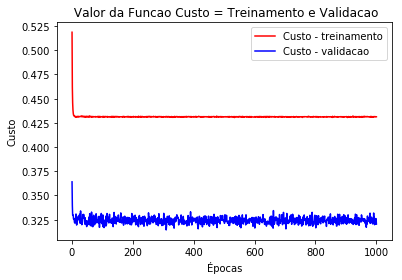

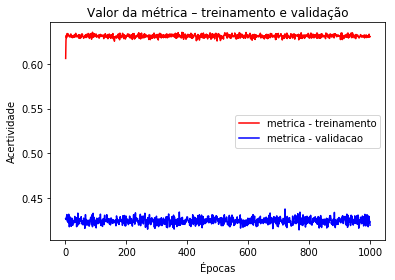

In [47]:
rna6.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna6.plot()

Confusion matrix, without normalization
[[16280  1657]
 [  900  1163]]


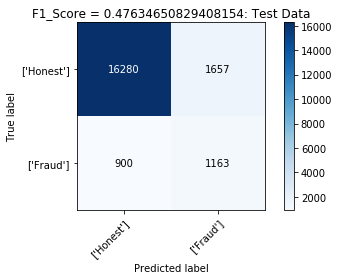

Confusion matrix, without normalization
[[16289  1693]
 [  822  1196]]


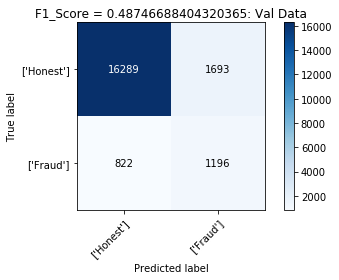

Confusion matrix, without normalization
[[40947  4028]
 [ 8320 11778]]


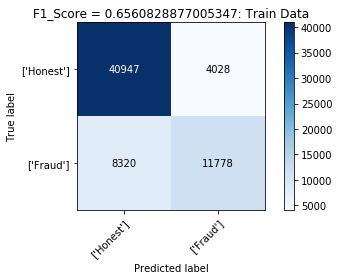

In [48]:
rna6.predict(x_data,y_data)

In [49]:
n_list7 = [50,1]
activation_list7 = ['tanh','sigmoid']
dropout_list7 = [0.2]

In [50]:
rna7 = new_rna_droplist()
rna7.build_model(data_shape,n_list7,activation_list7,dropout_list7)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 4s 61us/step - loss: 0.5140 - f1: 0.6139 - val_loss: 0.3582 - val_f1: 0.4272
Epoch 2/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4619 - f1: 0.6280 - val_loss: 0.3424 - val_f1: 0.4234
Epoch 3/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4460 - f1: 0.6312 - val_loss: 0.3382 - val_f1: 0.4278
Epoch 4/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4391 - f1: 0.6294 - val_loss: 0.3249 - val_f1: 0.4229
Epoch 5/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4351 - f1: 0.6296 - val_loss: 0.3292 - val_f1: 0.4256
Epoch 6/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4331 - f1: 0.6325 - val_loss: 0.3279 - val_f1: 0.4272
Epoch 7/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4320 - f1: 0.6328 - val_loss: 0.3205 - val_f1

65073/65073 [==============================] - 3s 52us/step - loss: 0.4315 - f1: 0.6322 - val_loss: 0.3277 - val_f1: 0.4292
Epoch 61/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4312 - f1: 0.6342 - val_loss: 0.3241 - val_f1: 0.4248
Epoch 62/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6343 - val_loss: 0.3259 - val_f1: 0.4258
Epoch 63/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6286 - val_loss: 0.3209 - val_f1: 0.4199
Epoch 64/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4318 - f1: 0.6290 - val_loss: 0.3229 - val_f1: 0.4250
Epoch 65/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4308 - f1: 0.6299 - val_loss: 0.3283 - val_f1: 0.4221
Epoch 66/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4314 - f1: 0.6326 - val_loss: 0.3304 - val_f1: 0.4240
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6339 - val_loss: 0.3225 - val_f1: 0.4253
Epoch 120/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6297 - val_loss: 0.3235 - val_f1: 0.4229
Epoch 121/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6286 - val_loss: 0.3236 - val_f1: 0.4296
Epoch 122/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6300 - val_loss: 0.3230 - val_f1: 0.4221
Epoch 123/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4317 - f1: 0.6327 - val_loss: 0.3216 - val_f1: 0.4270
Epoch 124/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6327 - val_loss: 0.3212 - val_f1: 0.4326
Epoch 125/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6311 - val_loss: 0.3237 - val_f1: 0.4197
Epoch 126/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6299 - val_loss: 0.3203 - val_f1: 0.4321
Epoch 179/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4311 - f1: 0.6269 - val_loss: 0.3254 - val_f1: 0.4291
Epoch 180/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6309 - val_loss: 0.3239 - val_f1: 0.4170
Epoch 181/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6313 - val_loss: 0.3224 - val_f1: 0.4224
Epoch 182/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6320 - val_loss: 0.3236 - val_f1: 0.4217
Epoch 183/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6304 - val_loss: 0.3238 - val_f1: 0.4239
Epoch 184/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4316 - f1: 0.6309 - val_loss: 0.3240 - val_f1: 0.4222
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6316 - val_loss: 0.3304 - val_f1: 0.4268
Epoch 238/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6308 - val_loss: 0.3245 - val_f1: 0.4284
Epoch 239/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4317 - f1: 0.6304 - val_loss: 0.3224 - val_f1: 0.4239
Epoch 240/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4309 - f1: 0.6289 - val_loss: 0.3221 - val_f1: 0.4234
Epoch 241/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4311 - f1: 0.6322 - val_loss: 0.3307 - val_f1: 0.4216
Epoch 242/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6335 - val_loss: 0.3206 - val_f1: 0.4293
Epoch 243/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6306 - val_loss: 0.3271 - val_f1: 0.4204
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6294 - val_loss: 0.3218 - val_f1: 0.4291
Epoch 297/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4318 - f1: 0.6326 - val_loss: 0.3279 - val_f1: 0.4307
Epoch 298/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4309 - f1: 0.6319 - val_loss: 0.3260 - val_f1: 0.4314
Epoch 299/1000
65073/65073 [==============================] - 4s 55us/step - loss: 0.4315 - f1: 0.6305 - val_loss: 0.3173 - val_f1: 0.4261
Epoch 300/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6322 - val_loss: 0.3197 - val_f1: 0.4250
Epoch 301/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4316 - f1: 0.6305 - val_loss: 0.3254 - val_f1: 0.4246
Epoch 302/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6311 - val_loss: 0.3268 - val_f1: 0.4232
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6314 - val_loss: 0.3245 - val_f1: 0.4233
Epoch 356/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4314 - f1: 0.6336 - val_loss: 0.3244 - val_f1: 0.4308
Epoch 357/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6267 - val_loss: 0.3229 - val_f1: 0.4234
Epoch 358/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6290 - val_loss: 0.3295 - val_f1: 0.4245
Epoch 359/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4307 - f1: 0.6299 - val_loss: 0.3260 - val_f1: 0.4196
Epoch 360/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4311 - f1: 0.6336 - val_loss: 0.3222 - val_f1: 0.4272
Epoch 361/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4317 - f1: 0.6322 - val_loss: 0.3228 - val_f1: 0.4266
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6297 - val_loss: 0.3230 - val_f1: 0.4308
Epoch 415/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6346 - val_loss: 0.3226 - val_f1: 0.4168
Epoch 416/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4316 - f1: 0.6326 - val_loss: 0.3279 - val_f1: 0.4248
Epoch 417/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4311 - f1: 0.6342 - val_loss: 0.3264 - val_f1: 0.4202
Epoch 418/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6326 - val_loss: 0.3233 - val_f1: 0.4246
Epoch 419/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4308 - f1: 0.6326 - val_loss: 0.3230 - val_f1: 0.4265
Epoch 420/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6330 - val_loss: 0.3212 - val_f1: 0.4308
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6291 - val_loss: 0.3223 - val_f1: 0.4305
Epoch 474/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4317 - f1: 0.6298 - val_loss: 0.3293 - val_f1: 0.4242
Epoch 475/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6336 - val_loss: 0.3271 - val_f1: 0.4273
Epoch 476/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6295 - val_loss: 0.3245 - val_f1: 0.4188
Epoch 477/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6291 - val_loss: 0.3258 - val_f1: 0.4237
Epoch 478/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4308 - f1: 0.6334 - val_loss: 0.3174 - val_f1: 0.4284
Epoch 479/1000
65073/65073 [==============================] - 4s 55us/step - loss: 0.4312 - f1: 0.6318 - val_loss: 0.3234 - val_f1: 0.4186
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6313 - val_loss: 0.3239 - val_f1: 0.4237
Epoch 533/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6351 - val_loss: 0.3288 - val_f1: 0.4241
Epoch 534/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6332 - val_loss: 0.3200 - val_f1: 0.4186
Epoch 535/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6349 - val_loss: 0.3263 - val_f1: 0.4276
Epoch 536/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4315 - f1: 0.6335 - val_loss: 0.3198 - val_f1: 0.4284
Epoch 537/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4310 - f1: 0.6306 - val_loss: 0.3282 - val_f1: 0.4197
Epoch 538/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4314 - f1: 0.6323 - val_loss: 0.3236 - val_f1: 0.4258
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6312 - val_loss: 0.3227 - val_f1: 0.4236
Epoch 592/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4315 - f1: 0.6330 - val_loss: 0.3251 - val_f1: 0.4285
Epoch 593/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6275 - val_loss: 0.3255 - val_f1: 0.4246
Epoch 594/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6289 - val_loss: 0.3228 - val_f1: 0.4265
Epoch 595/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4315 - f1: 0.6312 - val_loss: 0.3269 - val_f1: 0.4268
Epoch 596/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6318 - val_loss: 0.3216 - val_f1: 0.4200
Epoch 597/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4312 - f1: 0.6331 - val_loss: 0.3262 - val_f1: 0.4239
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 4s 54us/step - loss: 0.4314 - f1: 0.6295 - val_loss: 0.3215 - val_f1: 0.4227
Epoch 651/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4314 - f1: 0.6302 - val_loss: 0.3295 - val_f1: 0.4204
Epoch 652/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6301 - val_loss: 0.3294 - val_f1: 0.4245
Epoch 653/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4317 - f1: 0.6326 - val_loss: 0.3285 - val_f1: 0.4227
Epoch 654/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6346 - val_loss: 0.3258 - val_f1: 0.4234
Epoch 655/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4317 - f1: 0.6346 - val_loss: 0.3293 - val_f1: 0.4240
Epoch 656/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6334 - val_loss: 0.3210 - val_f1: 0.4251
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6306 - val_loss: 0.3223 - val_f1: 0.4222
Epoch 710/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4315 - f1: 0.6331 - val_loss: 0.3273 - val_f1: 0.4329
Epoch 711/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4311 - f1: 0.6309 - val_loss: 0.3248 - val_f1: 0.4316
Epoch 712/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4315 - f1: 0.6313 - val_loss: 0.3218 - val_f1: 0.4189
Epoch 713/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6290 - val_loss: 0.3227 - val_f1: 0.4201
Epoch 714/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6292 - val_loss: 0.3271 - val_f1: 0.4236
Epoch 715/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6319 - val_loss: 0.3208 - val_f1: 0.4199
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 54us/step - loss: 0.4310 - f1: 0.6304 - val_loss: 0.3217 - val_f1: 0.4217
Epoch 769/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6326 - val_loss: 0.3240 - val_f1: 0.4218
Epoch 770/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4317 - f1: 0.6295 - val_loss: 0.3299 - val_f1: 0.4272
Epoch 771/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6324 - val_loss: 0.3236 - val_f1: 0.4270
Epoch 772/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4314 - f1: 0.6312 - val_loss: 0.3191 - val_f1: 0.4273
Epoch 773/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4318 - f1: 0.6325 - val_loss: 0.3256 - val_f1: 0.4229
Epoch 774/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4314 - f1: 0.6339 - val_loss: 0.3221 - val_f1: 0.4242
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6335 - val_loss: 0.3248 - val_f1: 0.4200
Epoch 828/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6302 - val_loss: 0.3195 - val_f1: 0.4311
Epoch 829/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4313 - f1: 0.6290 - val_loss: 0.3161 - val_f1: 0.4221
Epoch 830/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4315 - f1: 0.6313 - val_loss: 0.3269 - val_f1: 0.4253
Epoch 831/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6310 - val_loss: 0.3258 - val_f1: 0.4237
Epoch 832/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6316 - val_loss: 0.3302 - val_f1: 0.4233
Epoch 833/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4314 - f1: 0.6329 - val_loss: 0.3250 - val_f1: 0.4193
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6296 - val_loss: 0.3234 - val_f1: 0.4209
Epoch 887/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4310 - f1: 0.6305 - val_loss: 0.3270 - val_f1: 0.4282
Epoch 888/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4314 - f1: 0.6306 - val_loss: 0.3233 - val_f1: 0.4255
Epoch 889/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6276 - val_loss: 0.3266 - val_f1: 0.4227
Epoch 890/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4311 - f1: 0.6334 - val_loss: 0.3185 - val_f1: 0.4238
Epoch 891/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4313 - f1: 0.6312 - val_loss: 0.3248 - val_f1: 0.4286
Epoch 892/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6316 - val_loss: 0.3208 - val_f1: 0.4235
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6295 - val_loss: 0.3219 - val_f1: 0.4350
Epoch 946/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6330 - val_loss: 0.3169 - val_f1: 0.4246
Epoch 947/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4313 - f1: 0.6312 - val_loss: 0.3234 - val_f1: 0.4195
Epoch 948/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4313 - f1: 0.6304 - val_loss: 0.3249 - val_f1: 0.4232
Epoch 949/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6307 - val_loss: 0.3203 - val_f1: 0.4234
Epoch 950/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6316 - val_loss: 0.3207 - val_f1: 0.4244
Epoch 951/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6301 - val_loss: 0.3269 - val_f1: 0.4206
Epoch 952/1000
65073/65073 [==============

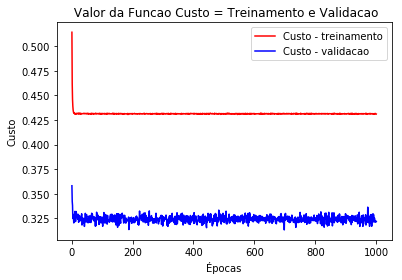

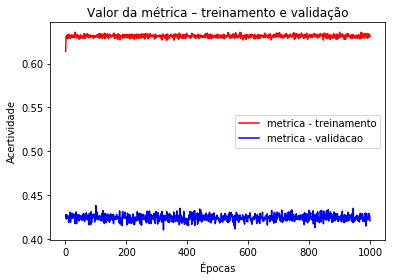

In [51]:
rna7.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna7.plot()

Confusion matrix, without normalization
[[16307  1630]
 [  902  1161]]


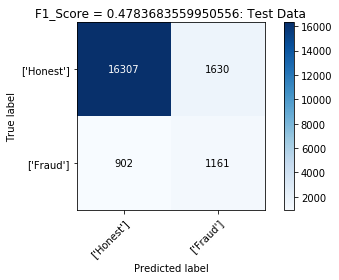

Confusion matrix, without normalization
[[16281  1701]
 [  810  1208]]


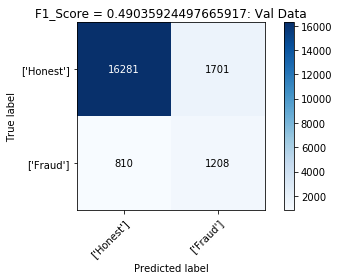

Confusion matrix, without normalization
[[40898  4077]
 [ 8352 11746]]


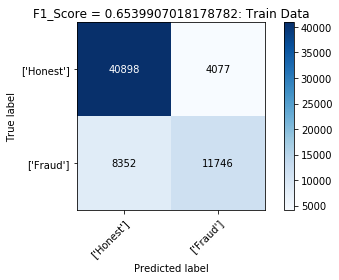

In [52]:
rna7.predict(x_data,y_data)

In [55]:
n_list8 = [50,1]
activation_list8 = ['tanh','sigmoid']
dropout_list8 = [0.2]

In [56]:
rna8 = new_rna_droplist()
rna8.build_model(data_shape,n_list8,activation_list8,dropout_list8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 4s 64us/step - loss: 0.5179 - f1: 0.6092 - val_loss: 0.3631 - val_f1: 0.4228
Epoch 2/1000
65073/65073 [==============================] - 4s 57us/step - loss: 0.4616 - f1: 0.6306 - val_loss: 0.3426 - val_f1: 0.4224
Epoch 3/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4464 - f1: 0.6299 - val_loss: 0.3343 - val_f1: 0.4279
Epoch 4/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4390 - f1: 0.6303 - val_loss: 0.3246 - val_f1: 0.4271
Epoch 5/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4351 - f1: 0.6322 - val_loss: 0.3244 - val_f1: 0.4237
Epoch 6/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4332 - f1: 0.6311 - val_loss: 0.3262 - val_f1: 0.4248
Epoch 7/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4322 - f1: 0.6336 - val_loss: 0.3272 - val_f1

65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6311 - val_loss: 0.3256 - val_f1: 0.4294
Epoch 99/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6314 - val_loss: 0.3214 - val_f1: 0.4318
Epoch 100/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4317 - f1: 0.6322 - val_loss: 0.3270 - val_f1: 0.4284
Epoch 101/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6344 - val_loss: 0.3210 - val_f1: 0.4260
Epoch 102/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6307 - val_loss: 0.3261 - val_f1: 0.4272
Epoch 103/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4314 - f1: 0.6321 - val_loss: 0.3184 - val_f1: 0.4212
Epoch 104/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4312 - f1: 0.6299 - val_loss: 0.3282 - val_f1: 0.4264
Epoch 105/1000
65073/65073 [===============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6343 - val_loss: 0.3265 - val_f1: 0.4242
Epoch 177/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6305 - val_loss: 0.3274 - val_f1: 0.4283
Epoch 178/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4315 - f1: 0.6302 - val_loss: 0.3246 - val_f1: 0.4275
Epoch 179/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4310 - f1: 0.6334 - val_loss: 0.3227 - val_f1: 0.4250
Epoch 180/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6301 - val_loss: 0.3264 - val_f1: 0.4257
Epoch 181/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6322 - val_loss: 0.3192 - val_f1: 0.4234
Epoch 201/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4311 - f1: 0.6327 - val_loss: 0.3224 - val_f1: 0.4204
Epoch 202/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6351 - val_loss: 0.3230 - val_f1: 0.4213
Epoch 255/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6327 - val_loss: 0.3189 - val_f1: 0.4174
Epoch 256/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4319 - f1: 0.6283 - val_loss: 0.3230 - val_f1: 0.4274
Epoch 257/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6309 - val_loss: 0.3320 - val_f1: 0.4199
Epoch 258/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6312 - val_loss: 0.3225 - val_f1: 0.4335
Epoch 259/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4313 - f1: 0.6307 - val_loss: 0.3250 - val_f1: 0.4270
Epoch 260/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6308 - val_loss: 0.3234 - val_f1: 0.4210
Epoch 261/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 53us/step - loss: 0.4314 - f1: 0.6297 - val_loss: 0.3226 - val_f1: 0.4179
Epoch 314/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6300 - val_loss: 0.3297 - val_f1: 0.4215
Epoch 315/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6312 - val_loss: 0.3310 - val_f1: 0.4229
Epoch 316/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6309 - val_loss: 0.3285 - val_f1: 0.4271
Epoch 317/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6326 - val_loss: 0.3246 - val_f1: 0.4248
Epoch 318/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6329 - val_loss: 0.3243 - val_f1: 0.4184
Epoch 319/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6332 - val_loss: 0.3202 - val_f1: 0.4161
Epoch 320/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6309 - val_loss: 0.3261 - val_f1: 0.4275
Epoch 373/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6353 - val_loss: 0.3265 - val_f1: 0.4227
Epoch 374/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6315 - val_loss: 0.3206 - val_f1: 0.4271
Epoch 375/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6290 - val_loss: 0.3222 - val_f1: 0.4220
Epoch 376/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4312 - f1: 0.6343 - val_loss: 0.3251 - val_f1: 0.4282
Epoch 377/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6286 - val_loss: 0.3268 - val_f1: 0.4195
Epoch 378/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4311 - f1: 0.6315 - val_loss: 0.3282 - val_f1: 0.4202
Epoch 379/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6323 - val_loss: 0.3206 - val_f1: 0.4233
Epoch 432/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4309 - f1: 0.6278 - val_loss: 0.3185 - val_f1: 0.4235
Epoch 433/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4313 - f1: 0.6307 - val_loss: 0.3226 - val_f1: 0.4212
Epoch 434/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6311 - val_loss: 0.3188 - val_f1: 0.4285
Epoch 435/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6312 - val_loss: 0.3256 - val_f1: 0.4227
Epoch 436/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6313 - val_loss: 0.3272 - val_f1: 0.4280
Epoch 437/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6303 - val_loss: 0.3247 - val_f1: 0.4183
Epoch 438/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6287 - val_loss: 0.3262 - val_f1: 0.4226
Epoch 491/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4315 - f1: 0.6336 - val_loss: 0.3144 - val_f1: 0.4200
Epoch 492/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6267 - val_loss: 0.3286 - val_f1: 0.4290
Epoch 493/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6303 - val_loss: 0.3264 - val_f1: 0.4246
Epoch 494/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6336 - val_loss: 0.3241 - val_f1: 0.4274
Epoch 495/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4311 - f1: 0.6299 - val_loss: 0.3256 - val_f1: 0.4295
Epoch 496/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4315 - f1: 0.6283 - val_loss: 0.3211 - val_f1: 0.4260
Epoch 497/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 52us/step - loss: 0.4313 - f1: 0.6312 - val_loss: 0.3225 - val_f1: 0.4188
Epoch 550/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6287 - val_loss: 0.3227 - val_f1: 0.4288
Epoch 551/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6274 - val_loss: 0.3234 - val_f1: 0.4273
Epoch 552/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6313 - val_loss: 0.3280 - val_f1: 0.4235
Epoch 553/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4315 - f1: 0.6320 - val_loss: 0.3201 - val_f1: 0.4290
Epoch 554/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4318 - f1: 0.6305 - val_loss: 0.3255 - val_f1: 0.4263
Epoch 555/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6324 - val_loss: 0.3263 - val_f1: 0.4231
Epoch 556/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4316 - f1: 0.6300 - val_loss: 0.3311 - val_f1: 0.4231
Epoch 609/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6329 - val_loss: 0.3264 - val_f1: 0.4252
Epoch 610/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6332 - val_loss: 0.3252 - val_f1: 0.4187
Epoch 611/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4312 - f1: 0.6338 - val_loss: 0.3272 - val_f1: 0.4251
Epoch 612/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6300 - val_loss: 0.3172 - val_f1: 0.4246
Epoch 613/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6307 - val_loss: 0.3291 - val_f1: 0.4249
Epoch 614/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6288 - val_loss: 0.3265 - val_f1: 0.4232
Epoch 615/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6328 - val_loss: 0.3247 - val_f1: 0.4322
Epoch 668/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6300 - val_loss: 0.3247 - val_f1: 0.4255
Epoch 669/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6324 - val_loss: 0.3251 - val_f1: 0.4194
Epoch 670/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4309 - f1: 0.6314 - val_loss: 0.3223 - val_f1: 0.4299
Epoch 671/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6351 - val_loss: 0.3276 - val_f1: 0.4240
Epoch 672/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6317 - val_loss: 0.3209 - val_f1: 0.4200
Epoch 673/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6309 - val_loss: 0.3279 - val_f1: 0.4214
Epoch 674/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4317 - f1: 0.6291 - val_loss: 0.3222 - val_f1: 0.4186
Epoch 727/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6318 - val_loss: 0.3231 - val_f1: 0.4305
Epoch 728/1000
65073/65073 [==============================] - 4s 55us/step - loss: 0.4312 - f1: 0.6324 - val_loss: 0.3284 - val_f1: 0.4222
Epoch 729/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4311 - f1: 0.6361 - val_loss: 0.3227 - val_f1: 0.4210
Epoch 730/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6296 - val_loss: 0.3232 - val_f1: 0.4213
Epoch 731/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4316 - f1: 0.6288 - val_loss: 0.3235 - val_f1: 0.4256
Epoch 732/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4311 - f1: 0.6313 - val_loss: 0.3237 - val_f1: 0.4273
Epoch 733/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6335 - val_loss: 0.3171 - val_f1: 0.4242
Epoch 786/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4311 - f1: 0.6305 - val_loss: 0.3254 - val_f1: 0.4260
Epoch 787/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4316 - f1: 0.6297 - val_loss: 0.3222 - val_f1: 0.4280
Epoch 788/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6303 - val_loss: 0.3257 - val_f1: 0.4210
Epoch 789/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6326 - val_loss: 0.3227 - val_f1: 0.4245
Epoch 790/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6293 - val_loss: 0.3219 - val_f1: 0.4221
Epoch 791/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4315 - f1: 0.6308 - val_loss: 0.3265 - val_f1: 0.4215
Epoch 792/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6312 - val_loss: 0.3162 - val_f1: 0.4295
Epoch 845/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6338 - val_loss: 0.3205 - val_f1: 0.4204
Epoch 846/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6324 - val_loss: 0.3242 - val_f1: 0.4231
Epoch 847/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4309 - f1: 0.6312 - val_loss: 0.3203 - val_f1: 0.4243
Epoch 848/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4311 - f1: 0.6318 - val_loss: 0.3201 - val_f1: 0.4204
Epoch 849/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6306 - val_loss: 0.3255 - val_f1: 0.4219
Epoch 850/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6315 - val_loss: 0.3266 - val_f1: 0.4207
Epoch 851/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6297 - val_loss: 0.3237 - val_f1: 0.4216
Epoch 904/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6311 - val_loss: 0.3263 - val_f1: 0.4251
Epoch 905/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6292 - val_loss: 0.3235 - val_f1: 0.4204
Epoch 906/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4316 - f1: 0.6339 - val_loss: 0.3260 - val_f1: 0.4249
Epoch 907/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6324 - val_loss: 0.3186 - val_f1: 0.4302
Epoch 908/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4311 - f1: 0.6296 - val_loss: 0.3228 - val_f1: 0.4251
Epoch 909/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6347 - val_loss: 0.3245 - val_f1: 0.4224
Epoch 910/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6317 - val_loss: 0.3242 - val_f1: 0.4221
Epoch 963/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6334 - val_loss: 0.3252 - val_f1: 0.4249
Epoch 964/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6328 - val_loss: 0.3246 - val_f1: 0.4342
Epoch 965/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4312 - f1: 0.6295 - val_loss: 0.3206 - val_f1: 0.4277
Epoch 966/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6336 - val_loss: 0.3225 - val_f1: 0.4268
Epoch 967/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6302 - val_loss: 0.3238 - val_f1: 0.4208
Epoch 968/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4317 - f1: 0.6306 - val_loss: 0.3286 - val_f1: 0.4254
Epoch 969/1000
65073/65073 [==============

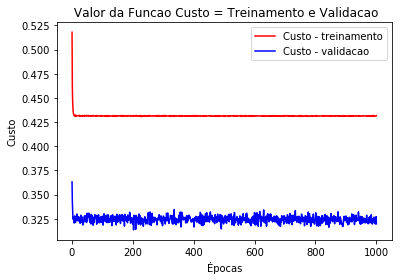

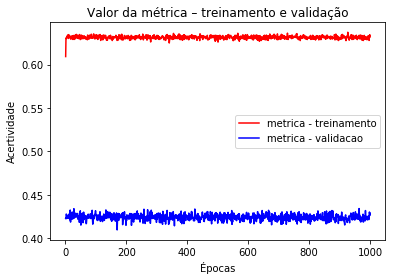

In [57]:
rna8.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna8.plot()

Confusion matrix, without normalization
[[16285  1652]
 [  890  1173]]


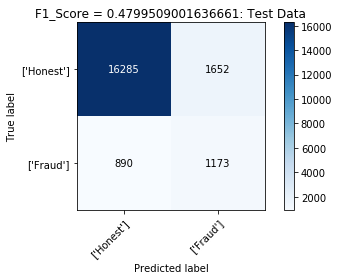

Confusion matrix, without normalization
[[16305  1677]
 [  800  1218]]


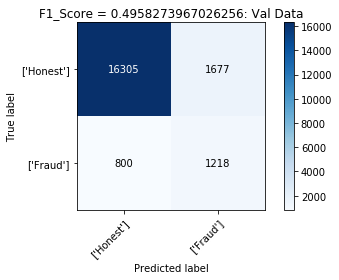

Confusion matrix, without normalization
[[40956  4019]
 [ 8347 11751]]


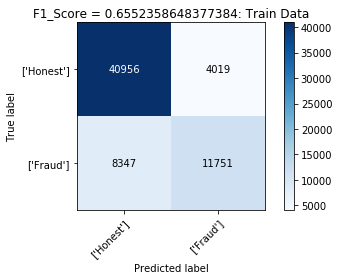

In [58]:
rna8.predict(x_data,y_data)

In [59]:
n_list9 = [50,1]
activation_list9 = ['tanh','sigmoid']
dropout_list9 = [0.2]

In [60]:
rna9 = new_rna_droplist()
rna9.build_model(data_shape,n_list9,activation_list9,dropout_list9)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 4s 57us/step - loss: 0.5152 - f1: 0.6115 - val_loss: 0.3687 - val_f1: 0.4308
Epoch 2/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4618 - f1: 0.6293 - val_loss: 0.3470 - val_f1: 0.4205
Epoch 3/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4464 - f1: 0.6282 - val_loss: 0.3360 - val_f1: 0.4259
Epoch 4/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4383 - f1: 0.6319 - val_loss: 0.3269 - val_f1: 0.4280
Epoch 5/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4349 - f1: 0.6286 - val_loss: 0.3236 - val_f1: 0.4274
Epoch 6/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4332 - f1: 0.6313 - val_loss: 0.3257 - val_f1: 0.4256
Epoch 7/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4323 - f1: 0.6301 - val_loss: 0.3268 - val_f1

65073/65073 [==============================] - 3s 49us/step - loss: 0.4314 - f1: 0.6293 - val_loss: 0.3251 - val_f1: 0.4324
Epoch 61/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4315 - f1: 0.6313 - val_loss: 0.3243 - val_f1: 0.4241
Epoch 62/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4317 - f1: 0.6301 - val_loss: 0.3216 - val_f1: 0.4282
Epoch 63/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4315 - f1: 0.6314 - val_loss: 0.3258 - val_f1: 0.4186
Epoch 64/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4314 - f1: 0.6332 - val_loss: 0.3219 - val_f1: 0.4158
Epoch 65/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4314 - f1: 0.6330 - val_loss: 0.3274 - val_f1: 0.4206
Epoch 66/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4311 - f1: 0.6318 - val_loss: 0.3249 - val_f1: 0.4229
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6286 - val_loss: 0.3243 - val_f1: 0.4242
Epoch 120/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6310 - val_loss: 0.3230 - val_f1: 0.4256
Epoch 121/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6321 - val_loss: 0.3203 - val_f1: 0.4274
Epoch 122/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6322 - val_loss: 0.3259 - val_f1: 0.4190
Epoch 123/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4316 - f1: 0.6307 - val_loss: 0.3220 - val_f1: 0.4265
Epoch 124/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6315 - val_loss: 0.3217 - val_f1: 0.4288
Epoch 125/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4317 - f1: 0.6308 - val_loss: 0.3214 - val_f1: 0.4312
Epoch 126/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4311 - f1: 0.6271 - val_loss: 0.3261 - val_f1: 0.4244
Epoch 179/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4314 - f1: 0.6329 - val_loss: 0.3263 - val_f1: 0.4262
Epoch 180/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6303 - val_loss: 0.3251 - val_f1: 0.4228
Epoch 181/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4307 - f1: 0.6291 - val_loss: 0.3277 - val_f1: 0.4175
Epoch 182/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6313 - val_loss: 0.3232 - val_f1: 0.4254
Epoch 183/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6298 - val_loss: 0.3203 - val_f1: 0.4338
Epoch 184/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4313 - f1: 0.6345 - val_loss: 0.3212 - val_f1: 0.4213
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6297 - val_loss: 0.3252 - val_f1: 0.4202
Epoch 238/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6280 - val_loss: 0.3296 - val_f1: 0.4259
Epoch 239/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4316 - f1: 0.6312 - val_loss: 0.3257 - val_f1: 0.4255
Epoch 240/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6319 - val_loss: 0.3220 - val_f1: 0.4219
Epoch 241/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4317 - f1: 0.6311 - val_loss: 0.3250 - val_f1: 0.4209
Epoch 242/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6347 - val_loss: 0.3237 - val_f1: 0.4249
Epoch 243/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6306 - val_loss: 0.3187 - val_f1: 0.4262
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6325 - val_loss: 0.3226 - val_f1: 0.4201
Epoch 297/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6322 - val_loss: 0.3198 - val_f1: 0.4231
Epoch 298/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6296 - val_loss: 0.3278 - val_f1: 0.4285
Epoch 299/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6312 - val_loss: 0.3298 - val_f1: 0.4235
Epoch 300/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6312 - val_loss: 0.3223 - val_f1: 0.4224
Epoch 301/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6330 - val_loss: 0.3227 - val_f1: 0.4275
Epoch 302/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6332 - val_loss: 0.3178 - val_f1: 0.4306
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6336 - val_loss: 0.3269 - val_f1: 0.4222
Epoch 356/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4311 - f1: 0.6329 - val_loss: 0.3236 - val_f1: 0.4229
Epoch 357/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6331 - val_loss: 0.3254 - val_f1: 0.4204
Epoch 358/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6300 - val_loss: 0.3198 - val_f1: 0.4228
Epoch 359/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4311 - f1: 0.6319 - val_loss: 0.3319 - val_f1: 0.4280
Epoch 360/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4310 - f1: 0.6319 - val_loss: 0.3205 - val_f1: 0.4248
Epoch 361/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6284 - val_loss: 0.3276 - val_f1: 0.4231
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4316 - f1: 0.6316 - val_loss: 0.3163 - val_f1: 0.4272
Epoch 415/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6309 - val_loss: 0.3248 - val_f1: 0.4283
Epoch 416/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6318 - val_loss: 0.3181 - val_f1: 0.4221
Epoch 417/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6311 - val_loss: 0.3189 - val_f1: 0.4264
Epoch 418/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6325 - val_loss: 0.3246 - val_f1: 0.4338
Epoch 419/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6298 - val_loss: 0.3327 - val_f1: 0.4235
Epoch 420/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6318 - val_loss: 0.3267 - val_f1: 0.4208
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6316 - val_loss: 0.3311 - val_f1: 0.4206
Epoch 474/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6308 - val_loss: 0.3281 - val_f1: 0.4195
Epoch 475/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6317 - val_loss: 0.3226 - val_f1: 0.4214
Epoch 476/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6304 - val_loss: 0.3234 - val_f1: 0.4200
Epoch 477/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6305 - val_loss: 0.3218 - val_f1: 0.4204
Epoch 478/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6342 - val_loss: 0.3229 - val_f1: 0.4231
Epoch 479/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6297 - val_loss: 0.3262 - val_f1: 0.4300
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 52us/step - loss: 0.4314 - f1: 0.6300 - val_loss: 0.3274 - val_f1: 0.4232
Epoch 533/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6306 - val_loss: 0.3228 - val_f1: 0.4245
Epoch 534/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6344 - val_loss: 0.3189 - val_f1: 0.4209
Epoch 535/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6312 - val_loss: 0.3250 - val_f1: 0.4199
Epoch 536/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6294 - val_loss: 0.3300 - val_f1: 0.4228
Epoch 537/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4310 - f1: 0.6358 - val_loss: 0.3218 - val_f1: 0.4157
Epoch 538/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6332 - val_loss: 0.3270 - val_f1: 0.4259
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4317 - f1: 0.6322 - val_loss: 0.3205 - val_f1: 0.4204
Epoch 592/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6303 - val_loss: 0.3285 - val_f1: 0.4299
Epoch 593/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6315 - val_loss: 0.3196 - val_f1: 0.4203
Epoch 594/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6295 - val_loss: 0.3255 - val_f1: 0.4233
Epoch 595/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6319 - val_loss: 0.3250 - val_f1: 0.4243
Epoch 596/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4308 - f1: 0.6322 - val_loss: 0.3265 - val_f1: 0.4264
Epoch 597/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6322 - val_loss: 0.3255 - val_f1: 0.4249
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 4s 54us/step - loss: 0.4312 - f1: 0.6331 - val_loss: 0.3231 - val_f1: 0.4213
Epoch 651/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6287 - val_loss: 0.3216 - val_f1: 0.4289
Epoch 652/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4309 - f1: 0.6344 - val_loss: 0.3213 - val_f1: 0.4250
Epoch 653/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6295 - val_loss: 0.3240 - val_f1: 0.4255
Epoch 654/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6289 - val_loss: 0.3252 - val_f1: 0.4231
Epoch 655/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4309 - f1: 0.6351 - val_loss: 0.3283 - val_f1: 0.4176
Epoch 656/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6301 - val_loss: 0.3261 - val_f1: 0.4274
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6335 - val_loss: 0.3242 - val_f1: 0.4300
Epoch 710/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4307 - f1: 0.6327 - val_loss: 0.3245 - val_f1: 0.4194
Epoch 711/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6316 - val_loss: 0.3196 - val_f1: 0.4216
Epoch 712/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4311 - f1: 0.6319 - val_loss: 0.3244 - val_f1: 0.4233
Epoch 713/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6304 - val_loss: 0.3249 - val_f1: 0.4251
Epoch 714/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4311 - f1: 0.6336 - val_loss: 0.3298 - val_f1: 0.4136
Epoch 715/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6343 - val_loss: 0.3230 - val_f1: 0.4259
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 52us/step - loss: 0.4313 - f1: 0.6323 - val_loss: 0.3223 - val_f1: 0.4236
Epoch 769/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6305 - val_loss: 0.3222 - val_f1: 0.4250
Epoch 770/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4314 - f1: 0.6299 - val_loss: 0.3245 - val_f1: 0.4218
Epoch 771/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4318 - f1: 0.6308 - val_loss: 0.3236 - val_f1: 0.4263
Epoch 772/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4316 - f1: 0.6315 - val_loss: 0.3232 - val_f1: 0.4269
Epoch 773/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6317 - val_loss: 0.3200 - val_f1: 0.4278
Epoch 774/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4314 - f1: 0.6295 - val_loss: 0.3320 - val_f1: 0.4265
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 53us/step - loss: 0.4314 - f1: 0.6288 - val_loss: 0.3237 - val_f1: 0.4207
Epoch 828/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6265 - val_loss: 0.3260 - val_f1: 0.4259
Epoch 829/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6306 - val_loss: 0.3230 - val_f1: 0.4253
Epoch 830/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6334 - val_loss: 0.3229 - val_f1: 0.4251
Epoch 831/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6323 - val_loss: 0.3254 - val_f1: 0.4228
Epoch 832/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4312 - f1: 0.6311 - val_loss: 0.3231 - val_f1: 0.4226
Epoch 833/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6341 - val_loss: 0.3245 - val_f1: 0.4207
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6313 - val_loss: 0.3207 - val_f1: 0.4225
Epoch 887/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6337 - val_loss: 0.3235 - val_f1: 0.4231
Epoch 888/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6301 - val_loss: 0.3257 - val_f1: 0.4170
Epoch 889/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4314 - f1: 0.6310 - val_loss: 0.3231 - val_f1: 0.4247
Epoch 890/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4307 - f1: 0.6341 - val_loss: 0.3274 - val_f1: 0.4224
Epoch 891/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6338 - val_loss: 0.3181 - val_f1: 0.4244
Epoch 892/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6329 - val_loss: 0.3296 - val_f1: 0.4214
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6311 - val_loss: 0.3270 - val_f1: 0.4249
Epoch 946/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4313 - f1: 0.6302 - val_loss: 0.3258 - val_f1: 0.4183
Epoch 947/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6309 - val_loss: 0.3230 - val_f1: 0.4250
Epoch 948/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6326 - val_loss: 0.3183 - val_f1: 0.4188
Epoch 949/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6287 - val_loss: 0.3246 - val_f1: 0.4191
Epoch 950/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6304 - val_loss: 0.3248 - val_f1: 0.4203
Epoch 951/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4315 - f1: 0.6309 - val_loss: 0.3285 - val_f1: 0.4311
Epoch 952/1000
65073/65073 [==============

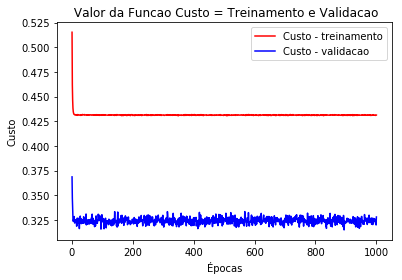

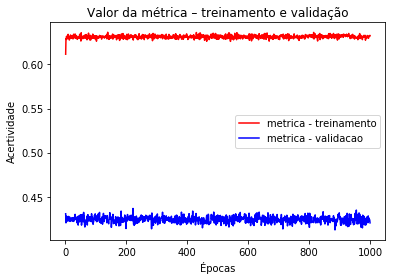

In [61]:
rna9.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna9.plot()

Confusion matrix, without normalization
[[16165  1772]
 [  853  1210]]


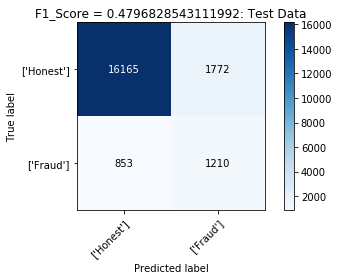

Confusion matrix, without normalization
[[16181  1801]
 [  790  1228]]


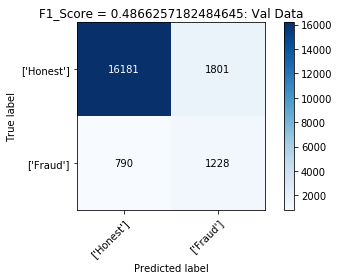

Confusion matrix, without normalization
[[40634  4341]
 [ 8036 12062]]


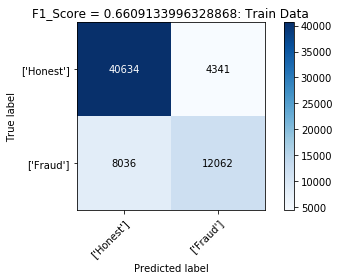

In [62]:
rna9.predict(x_data,y_data)

In [63]:
n_list10 = [50,1]
activation_list10 = ['tanh','sigmoid']
dropout_list10 = [0.2]

In [64]:
rna10 = new_rna_droplist()
rna10.build_model(data_shape,n_list10,activation_list10,dropout_list10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 4s 58us/step - loss: 0.5191 - f1: 0.6066 - val_loss: 0.3577 - val_f1: 0.4220
Epoch 2/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4623 - f1: 0.6281 - val_loss: 0.3415 - val_f1: 0.4298
Epoch 3/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4464 - f1: 0.6286 - val_loss: 0.3319 - val_f1: 0.4278
Epoch 4/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4385 - f1: 0.6304 - val_loss: 0.3284 - val_f1: 0.4194
Epoch 5/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4351 - f1: 0.6320 - val_loss: 0.3259 - val_f1: 0.4249
Epoch 6/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4335 - f1: 0.6301 - val_loss: 0.3233 - val_f1: 0.4230
Epoch 7/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4325 - f1: 0.6307 - val_loss: 0.3221 - val_f1

65073/65073 [==============================] - 3s 53us/step - loss: 0.4313 - f1: 0.6313 - val_loss: 0.3209 - val_f1: 0.4237
Epoch 61/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6294 - val_loss: 0.3288 - val_f1: 0.4245
Epoch 62/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4317 - f1: 0.6321 - val_loss: 0.3207 - val_f1: 0.4191
Epoch 63/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6307 - val_loss: 0.3182 - val_f1: 0.4231
Epoch 64/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4317 - f1: 0.6327 - val_loss: 0.3248 - val_f1: 0.4230
Epoch 65/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4316 - f1: 0.6318 - val_loss: 0.3244 - val_f1: 0.4313
Epoch 66/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4317 - f1: 0.6335 - val_loss: 0.3167 - val_f1: 0.4216
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6283 - val_loss: 0.3204 - val_f1: 0.4284
Epoch 120/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6285 - val_loss: 0.3236 - val_f1: 0.4250
Epoch 121/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6315 - val_loss: 0.3260 - val_f1: 0.4289
Epoch 122/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4310 - f1: 0.6337 - val_loss: 0.3236 - val_f1: 0.4194
Epoch 123/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4314 - f1: 0.6311 - val_loss: 0.3200 - val_f1: 0.4212
Epoch 124/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4318 - f1: 0.6313 - val_loss: 0.3263 - val_f1: 0.4250
Epoch 125/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4313 - f1: 0.6332 - val_loss: 0.3277 - val_f1: 0.4251
Epoch 126/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 52us/step - loss: 0.4310 - f1: 0.6301 - val_loss: 0.3155 - val_f1: 0.4241
Epoch 179/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6311 - val_loss: 0.3187 - val_f1: 0.4290
Epoch 180/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6338 - val_loss: 0.3257 - val_f1: 0.4230
Epoch 181/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4313 - f1: 0.6322 - val_loss: 0.3227 - val_f1: 0.4233
Epoch 182/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6320 - val_loss: 0.3237 - val_f1: 0.4283
Epoch 183/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6346 - val_loss: 0.3212 - val_f1: 0.4257
Epoch 184/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6296 - val_loss: 0.3226 - val_f1: 0.4311
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6328 - val_loss: 0.3207 - val_f1: 0.4227
Epoch 238/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4318 - f1: 0.6313 - val_loss: 0.3242 - val_f1: 0.4279
Epoch 239/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6297 - val_loss: 0.3236 - val_f1: 0.4241
Epoch 240/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6296 - val_loss: 0.3274 - val_f1: 0.4271
Epoch 241/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4310 - f1: 0.6330 - val_loss: 0.3206 - val_f1: 0.4261
Epoch 242/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4318 - f1: 0.6288 - val_loss: 0.3290 - val_f1: 0.4198
Epoch 243/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4315 - f1: 0.6322 - val_loss: 0.3270 - val_f1: 0.4174
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6322 - val_loss: 0.3236 - val_f1: 0.4319
Epoch 297/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6329 - val_loss: 0.3212 - val_f1: 0.4171
Epoch 298/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6322 - val_loss: 0.3205 - val_f1: 0.4237
Epoch 299/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6289 - val_loss: 0.3271 - val_f1: 0.4227
Epoch 300/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4313 - f1: 0.6305 - val_loss: 0.3258 - val_f1: 0.4262
Epoch 301/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6300 - val_loss: 0.3291 - val_f1: 0.4258
Epoch 302/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6305 - val_loss: 0.3256 - val_f1: 0.4267
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6302 - val_loss: 0.3241 - val_f1: 0.4214
Epoch 356/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6302 - val_loss: 0.3239 - val_f1: 0.4218
Epoch 357/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4311 - f1: 0.6318 - val_loss: 0.3198 - val_f1: 0.4269
Epoch 358/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6304 - val_loss: 0.3271 - val_f1: 0.4244
Epoch 359/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6316 - val_loss: 0.3198 - val_f1: 0.4239
Epoch 360/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4316 - f1: 0.6288 - val_loss: 0.3260 - val_f1: 0.4201
Epoch 361/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4311 - f1: 0.6302 - val_loss: 0.3205 - val_f1: 0.4261
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 53us/step - loss: 0.4310 - f1: 0.6330 - val_loss: 0.3293 - val_f1: 0.4244
Epoch 415/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4310 - f1: 0.6330 - val_loss: 0.3269 - val_f1: 0.4149
Epoch 416/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6308 - val_loss: 0.3270 - val_f1: 0.4283
Epoch 417/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4311 - f1: 0.6313 - val_loss: 0.3228 - val_f1: 0.4278
Epoch 418/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6339 - val_loss: 0.3227 - val_f1: 0.4140
Epoch 419/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4315 - f1: 0.6290 - val_loss: 0.3244 - val_f1: 0.4294
Epoch 420/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6339 - val_loss: 0.3257 - val_f1: 0.4250
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6319 - val_loss: 0.3296 - val_f1: 0.4209
Epoch 474/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6319 - val_loss: 0.3258 - val_f1: 0.4208
Epoch 475/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6325 - val_loss: 0.3149 - val_f1: 0.4254
Epoch 476/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4311 - f1: 0.6329 - val_loss: 0.3206 - val_f1: 0.4257
Epoch 477/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4316 - f1: 0.6306 - val_loss: 0.3197 - val_f1: 0.4269
Epoch 478/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4310 - f1: 0.6298 - val_loss: 0.3253 - val_f1: 0.4244
Epoch 479/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6308 - val_loss: 0.3198 - val_f1: 0.4218
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6318 - val_loss: 0.3302 - val_f1: 0.4265
Epoch 533/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4314 - f1: 0.6325 - val_loss: 0.3243 - val_f1: 0.4213
Epoch 534/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4310 - f1: 0.6315 - val_loss: 0.3213 - val_f1: 0.4271
Epoch 535/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6324 - val_loss: 0.3263 - val_f1: 0.4261
Epoch 536/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4317 - f1: 0.6307 - val_loss: 0.3278 - val_f1: 0.4249
Epoch 537/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6320 - val_loss: 0.3188 - val_f1: 0.4192
Epoch 538/1000
65073/65073 [==============================] - 4s 54us/step - loss: 0.4314 - f1: 0.6314 - val_loss: 0.3235 - val_f1: 0.4172
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6321 - val_loss: 0.3257 - val_f1: 0.4258
Epoch 592/1000
65073/65073 [==============================] - 4s 55us/step - loss: 0.4316 - f1: 0.6317 - val_loss: 0.3207 - val_f1: 0.4256
Epoch 593/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6295 - val_loss: 0.3227 - val_f1: 0.4257
Epoch 594/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6313 - val_loss: 0.3233 - val_f1: 0.4245
Epoch 595/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4312 - f1: 0.6310 - val_loss: 0.3288 - val_f1: 0.4272
Epoch 596/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6336 - val_loss: 0.3288 - val_f1: 0.4249
Epoch 597/1000
65073/65073 [==============================] - 4s 56us/step - loss: 0.4310 - f1: 0.6327 - val_loss: 0.3206 - val_f1: 0.4235
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6331 - val_loss: 0.3236 - val_f1: 0.4242
Epoch 651/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4313 - f1: 0.6294 - val_loss: 0.3251 - val_f1: 0.4278
Epoch 652/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6314 - val_loss: 0.3251 - val_f1: 0.4228
Epoch 653/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6343 - val_loss: 0.3247 - val_f1: 0.4234
Epoch 654/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4313 - f1: 0.6322 - val_loss: 0.3264 - val_f1: 0.4213
Epoch 655/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6337 - val_loss: 0.3220 - val_f1: 0.4221
Epoch 656/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6305 - val_loss: 0.3293 - val_f1: 0.4244
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4310 - f1: 0.6351 - val_loss: 0.3187 - val_f1: 0.4204
Epoch 710/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6298 - val_loss: 0.3216 - val_f1: 0.4269
Epoch 711/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4313 - f1: 0.6319 - val_loss: 0.3265 - val_f1: 0.4225
Epoch 712/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6286 - val_loss: 0.3268 - val_f1: 0.4191
Epoch 713/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6339 - val_loss: 0.3276 - val_f1: 0.4222
Epoch 714/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4308 - f1: 0.6319 - val_loss: 0.3255 - val_f1: 0.4282
Epoch 715/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6298 - val_loss: 0.3252 - val_f1: 0.4257
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4314 - f1: 0.6281 - val_loss: 0.3199 - val_f1: 0.4271
Epoch 769/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4311 - f1: 0.6320 - val_loss: 0.3237 - val_f1: 0.4210
Epoch 770/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6299 - val_loss: 0.3303 - val_f1: 0.4289
Epoch 771/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6318 - val_loss: 0.3207 - val_f1: 0.4230
Epoch 772/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4308 - f1: 0.6308 - val_loss: 0.3219 - val_f1: 0.4213
Epoch 773/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6291 - val_loss: 0.3250 - val_f1: 0.4257
Epoch 774/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4314 - f1: 0.6339 - val_loss: 0.3236 - val_f1: 0.4276
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6323 - val_loss: 0.3251 - val_f1: 0.4306
Epoch 828/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4309 - f1: 0.6335 - val_loss: 0.3178 - val_f1: 0.4318
Epoch 829/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6299 - val_loss: 0.3238 - val_f1: 0.4272
Epoch 830/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6308 - val_loss: 0.3305 - val_f1: 0.4301
Epoch 831/1000
65073/65073 [==============================] - 4s 55us/step - loss: 0.4313 - f1: 0.6315 - val_loss: 0.3249 - val_f1: 0.4294
Epoch 832/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6306 - val_loss: 0.3231 - val_f1: 0.4228
Epoch 833/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6316 - val_loss: 0.3294 - val_f1: 0.4228
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4312 - f1: 0.6316 - val_loss: 0.3269 - val_f1: 0.4265
Epoch 887/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4315 - f1: 0.6325 - val_loss: 0.3250 - val_f1: 0.4227
Epoch 888/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4312 - f1: 0.6306 - val_loss: 0.3287 - val_f1: 0.4236
Epoch 889/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6341 - val_loss: 0.3176 - val_f1: 0.4215
Epoch 890/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6313 - val_loss: 0.3252 - val_f1: 0.4228
Epoch 891/1000
65073/65073 [==============================] - 3s 52us/step - loss: 0.4312 - f1: 0.6315 - val_loss: 0.3287 - val_f1: 0.4224
Epoch 892/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6308 - val_loss: 0.3170 - val_f1: 0.4214
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 54us/step - loss: 0.4311 - f1: 0.6325 - val_loss: 0.3223 - val_f1: 0.4192
Epoch 946/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4315 - f1: 0.6298 - val_loss: 0.3275 - val_f1: 0.4192
Epoch 947/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4313 - f1: 0.6295 - val_loss: 0.3243 - val_f1: 0.4191
Epoch 948/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4314 - f1: 0.6287 - val_loss: 0.3275 - val_f1: 0.4231
Epoch 949/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4311 - f1: 0.6293 - val_loss: 0.3291 - val_f1: 0.4274
Epoch 950/1000
65073/65073 [==============================] - 3s 54us/step - loss: 0.4315 - f1: 0.6311 - val_loss: 0.3236 - val_f1: 0.4266
Epoch 951/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4316 - f1: 0.6309 - val_loss: 0.3306 - val_f1: 0.4287
Epoch 952/1000
65073/65073 [==============

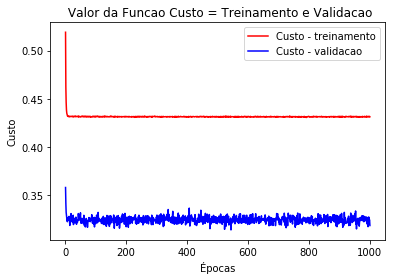

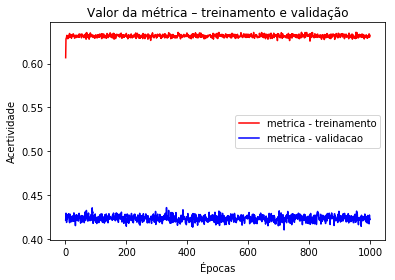

In [65]:
rna10.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna10.plot()

Confusion matrix, without normalization
[[16311  1626]
 [  887  1176]]


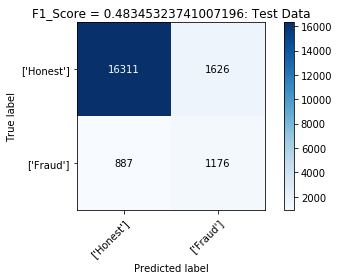

Confusion matrix, without normalization
[[16315  1667]
 [  821  1197]]


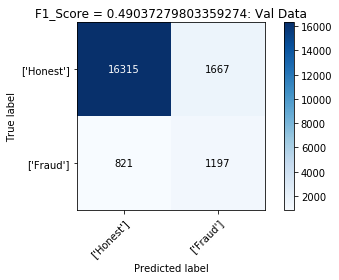

Confusion matrix, without normalization
[[40987  3988]
 [ 8386 11712]]


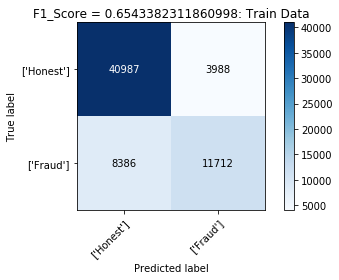

In [66]:
rna10.predict(x_data,y_data)